# Recipe Classifier Notebook 030: Modelling

**Author**: Andrew Yew Chean Yang <br>
**Date**: 2023-04-11<br>

Table of contents are available for JupyterLab

# Notebook introduction
This notebook builds on top of the previous notebook `020: eda_feature_engineering`. The final processed dataset was used to determine the best model, optimize hyperparameters, and train the model for classifying recipes into the target variable `recipe_worth_it`, with 'worth_it'(1) being recipes with an average rating of greater than or equal to 4.5. Regression, distance based, and ensemble classifier models were tested in this notebook. Metrics used for evaluating model performance were overall accuracy with precision and recall for the 'worth_it' class. Ultimately, a LogisticRegression model was chosen as it provided the same level of performance as XGBoost, an ensemble method, but used a variety of features whereas XGBoost was found to depend entirely on just the 'review' column. 

In terms of modelling workflow:
1. Null values were imputed using KNN imputer

2. Categorical columns and text columns were vectorized using ColumnTransformer with One Hot Encoder (OHE) and Term Frequency-Inverse Document Frequency(TF-IDF)

3. Data was split into remainder and test sets
- Test set, reserved only for the one final time testing of thee final decided model.
- Remainder set, used for cross validation, further split into train and validation
4. Base models were trained and tested using train and validation datasets

- Metrics: accuracy, precision and recall of 'worth it' class
5. Candidates for final model were trained using Pipelines and GridsearchCV to finetune hyperparameters

6. Final model trained on remainder data and best hyperparameters
- final accuracy reported using test data.

## Warning
Many of the cells in this notebook require more than 15 minutes to run, with the hyperparameter optimization taking at least a few hours to run. Furthermore, due to the verbose setting of GridsearchCV, there may be long episodes of progress texts.

# Import Required Packages

In [45]:
# Packages for processing data
import numpy as np
import pandas as pd

# Packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for pickling and loading pickle files.
import joblib 
import time

# Packages for statistical testing
from scipy import stats # chi-square test

# Packages for data preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

# Packages for natural language processing
import nltk # Natural Language Tool Kit
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Packages for models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Packages for model hyperparameter optimization
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# Packages for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import shap

[nltk_data] Downloading package stopwords to /Users/hubba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Define Global Variables and Functions

In [8]:
# Setting random state to 42 for consistent reproduction of results
rs = 42

In [53]:
def my_tokenizer(sentence):
    """
    Custom tokenizer for preprocessing of text columns.
    
    Usage
    -----
    Used as the tokenizer hyperparameter for vectorizers such as CountVectorizer() and TfIdf
    
    Input
    -----
    string, raw document.
    
    Output
    ------
    list of strings, cleaned & stemmed tokens
    """
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()
    
    # remove all numerical digits in the text
    # https://stackoverflow.com/questions/12851791/removing-numbers-from-string
    remove_digits = str.maketrans('','', string.digits)
    sentence = sentence.translate(remove_digits)

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # define English stop words
    ENGLISH_STOP_WORDS = stopwords.words('english')
    # add in additional stop words that are specific to cooking
    ENGLISH_STOP_WORDS.extend(['degree','degrees','c','f', 'recipe', 'recipes', 'minute', 'minutes'])
    
    # define stemmer
    stemmer = nltk.stem.PorterStemmer()
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [444]:
def vectorizer(df, col, min_df, ngram_range, max_features,y, model = 'tfidf'):
    """
    A function that fits a vectorizer and a returns the fitted vectorizer along with graphs analyzing ngram importance with a distribution analysis of the target feature
    
    Usage
    -----
    Used to test and examine vectorizers in detail.
    
    Input
    -----
    df: DataFrame containing the text column
    col: Text column within df
    min_df: hyperparameter for vectorizers, the minimum frequency of an ngram to be included
    ngram_range: how many words to include per ngram
    max_features: number of features generated from vectorizer
    y: target feature to do distribution analysis for
    model: by default is tfidf
    
    Output
    ------
    bagofwords: the fitted vectorizer
    temp_df: DataFrame containing ngrams witth their importance
    column_vectorized: DataFrame containing vectorized text column
    """
    start = time.perf_counter()
    
    # Select CountVectorizer or TfIdf
    if model == 'tfidf':
        bagofwords = TfidfVectorizer(min_df = min_df,
                                     tokenizer = my_tokenizer,
                                     ngram_range = ngram_range,
                                     max_features = max_features)
    else:
        # Initiate bag of words model
        bagofwords = CountVectorizer(min_df = min_df, 
                                     tokenizer = my_tokenizer,
                                     ngram_range = ngram_range,
                                     max_features = max_features)
    
    # Train bag of words model using data
    X_transformed = bagofwords.fit_transform(df[col])
    
    # Transform sparse matrix into dataframe
    column_vectorized = pd.DataFrame(X_transformed.toarray(),
                                     columns = bagofwords.get_feature_names_out())
    
    end = time.perf_counter()
    
    # Combine y_train with the vectorized column
    temp_df = pd.merge(column_vectorized, 
                       y, 
                       left_index = True, 
                       right_index = True)
    
    # Groupby y_train column to generate summary statistic for each catgory in y_train
    temp_df             = temp_df.groupby(by = 'recipe_worth_it').sum().T
    
    print(f"========== FOR COLUMN: {col} ==========")
    print(f"Number of ngrams for {col}: {temp_df.shape[0]}")
    print(f"Parameters: min_df = {min_df}, ngram_range = {ngram_range}, max_features = {max_features}")
    
    # Total count for each word is the sum of the y_train groups. 
    # To ensure rounding to 100%, the other label is derived from the first label
    temp_df['total']    = temp_df[0] + temp_df[1]
    temp_df['0_labels'] = np.round(temp_df[0] / temp_df['total'] * 100,0)
    temp_df['1_labels'] = 100 - temp_df['0_labels']
    temp_df['0_labels'] = temp_df['0_labels'].astype(int)
    temp_df['1_labels'] = temp_df['1_labels'].astype(int)
    temp_df = temp_df.sort_values(by = 'total',
                                  ascending = False)
    
    
    ## Plot the 20 most frequently appearing ngrams
    # Initiate figure object
    plt.figure(figsize = (12,5), dpi = 300)
    
    # Create a plot_dataframe where only top 20 ngrams are taken
    plot_df = temp_df.head(20)
    
    # Create plot for y_train categories: 0 (Not worth it), 1 (worth it)
    plot_df[[0,1]].plot.bar(stacked = True,
                            ax = plt.gca())

    # Create labels for each data point
    labels = plot_df['0_labels'].to_list() + plot_df['1_labels'].to_list()
    
    # Initiate axis object and call on patches
    ax = plt.gca()
    rects = ax.patches
    
    # Generate a list of heights for labels.
    heights = [rect.get_height() for rect in rects]
    heights = [heights[i] if i < len(labels)/2 else heights[i]+heights[int(i-len(labels)/2)] for i in range(0,len(labels))]
    
    # Add in labels to the plot
    # Reference https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart
    for rect, label, height in zip(rects, labels, heights):
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    
    # Despine for neatness and show
    plt.title(f"Top 20 most frequent ngrams for {col}")
    plt.ylabel(f"Frequency of ngram")
    sns.despine()
    plt.show()

    
    ## Plot the 20 least frequently appearing ngrams
    # Initiate figure object
    plt.figure(figsize = (12,5), dpi = 300)
    
    # Create a plot_dataframe where only top 20 ngrams are taken
    plot_df = temp_df.tail(20)
    
    # Create plot for y_train categories: 0 (Not worth it), 1 (worth it)
    plot_df[[0,1]].plot.bar(stacked = True,
                            ax = plt.gca())

    # Create labels for each data point
    labels = plot_df['0_labels'].to_list() + plot_df['1_labels'].to_list()
    
    # Initiate axis object and call on patches
    ax = plt.gca()
    rects = ax.patches
    
    # Generate a list of heights for labels.
    heights = [rect.get_height() for rect in rects]
    heights = [heights[i] if i < len(labels)/2 else heights[i]+heights[int(i-len(labels)/2)] for i in range(0,len(labels))]
    
    # Add in labels to the plot
    # Reference https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart
    for rect, label, height in zip(rects, labels, heights):
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    
    # Despine for neatness and show
    plt.title(f"Bottom 20 most frequent ngrams for {col}")
    plt.ylabel(f"Frequency of ngram")
    sns.despine()
    plt.show()
    
    print(f"===================================")
    print("")
    print("")
    
    return bagofwords, temp_df, column_vectorized

In [119]:
def plot_distribution(df, col):
    '''
    Plots 2 subplots: 
    Left subplot: histogram without any transformation. The mean and median lines were included.
    Right subplot: histogram with LOG transformation and on LOG scale. The mean and median lines were included.
    
    Usecase in project: used in the EDA section to determine skewed distributions with outliers, and to determine if LOG should be applied to center skewed distributions and deal with outliers without dropping rows
    
    Input
    -----
    df  : DataFrame that contains the continuous numerical column
    col : Categorical column to plot distribution 
    
    Output
    ------
    Two subplots of histogram, left without transformation and right with LOG transformation
    
    Examples
    --------
    Given DataFrame 'df1' and categorical column 'col1':
    
    plot_distribution(df1,'col1')
    
    '''
    # Start timer
    start = time.perf_counter()
    print(f"===== Distribution Plots for {col} =====")
    
    # Create subplot object with 1 row and 2 columns
    plt.subplots(1, 2, figsize = (15,5))

    # Calculate the summary statistics for column
    col_mean = np.mean(df[col])
    col_median = np.median(df[col])

    # Plot first histogram to show distribution as is
    plt.subplot(1,2,1)
    sns.histplot(data = df, x = col, stat = 'probability');
    plt.axvline(col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(col_mean,2)}")
    plt.axvline(col_median, linestyle = '--', c = 'red', label = f"median: {np.round(col_median,2)}")
    plt.legend()
    plt.title(f"Distribution for {col}")

    # Plot second histogram to show log distribution
    # Calculate log of column
    log_df = np.log(df+1)
    log_col_mean = np.mean(log_df[col])
    log_col_median = np.median(log_df[col])

    # Plot second histogram to show LOG distribution
    plt.subplot(1,2,2)
    sns.histplot(data = log_df, x = col, stat = 'probability');
    plt.axvline(log_col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(log_col_mean,2)}")
    plt.axvline(log_col_median, linestyle = '--', c = 'red', label = f"median: {np.round(log_col_median,2)}")
    plt.xlabel(f"LOG {col}")
    plt.legend()
    plt.title(f"LOG Distribution for {col}")

    sns.despine()
    plt.show()
    
    # End timer 
    end = time.perf_counter()
    print(f"Time taken : {np.round(end - start,3)} seconds.")
    print(f"===============================================")
    print(f"")
    print(f"")

In [148]:
def base_model_fit(X_rem, y_rem, X_test, y_test, model_object):
    '''
    Fits a model using default parameters and returns remainder and test accuracies.
    Remainder: train + validation data
    
    Usecase in project: used to build the base model of each classifier
    
    Input
    -----
    X_rem : Remainder independent variables (train + validation)
    y_rem : Remainder dependent variables (train + validation)
    X_test : Test independent variables
    y_test : Test dependent variables 
    model_object : sklearn models such as DecisionTreeClassifier()
    
    Output
    ------
    Remainder accuracy
    Test accuracy
    Time taken (seconds)
    '''
    # Start timer
    start = time.perf_counter()
    
    # Initiate the model with no parameters set
    model = model_object
    
    # Fit the model
    model.fit(X_rem,y_rem)
    
    # Print the train and validation scores
    print(f"Base fitting of a {str(model)} with no hyperparameter adjustment.")
    print(f"Accuracy for train data: {np.round(model.score(X_rem,y_rem)*100,2)}%")
    print(f"Accuracy for validation data: {np.round(model.score(X_test,y_test)*100,2)}%")
    
    # End timmer
    end = time.perf_counter()
    print(f"Time taken:{np.round(end-start,4)} seconds")
    return model

In [309]:
def generate_confusion_matrix(X_val,y_val,model, model_name):
    '''
    Generates a confusion matrix for a given model
    
    Usecase in project: used to examine confusion matrix for a given model
    
    Input
    -----
    X_val : Independent variables
    y_val : Dependent variable
    model : a fitted model
    
    Output
    ------
    Confusion matrix plot and precision and classification report
    '''
    
    # Generate predictions using a default threshold of 0.5
    y_pred = model.predict(X_val)
    
    # Print the classification report
    print(f"{model_name}: Classification report for a threshold of 0.5 + confusion matrix\n")
    print(classification_report(y_val, y_pred))
    
    # Create confusion matrix (1 is positive sentiment, 0 is negative sentiment
    cm = confusion_matrix(y_val, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = model.classes_)
    disp.plot()
    plt.show()

# Load Processed Data

In [288]:
# Load the pickle file containing the processed data
processed_df = joblib.load('data/final_processed_df.pkl')
print(f"Loaded data has {processed_df.shape[0]} rows and {processed_df.shape[1]} columns.")

Loaded data has 33691 rows and 31 columns.


# Split Data into Remainder and Test Sets

In [13]:
print(f"Checking proportions of target feature")
print(processed_df['recipe_worth_it'].value_counts(normalize = True))

Checking proportions of target feature
1    0.584815
0    0.415185
Name: recipe_worth_it, dtype: float64


58.5% of the recipes were rated as 'worth it' (>=4.5 average rating) while 41.5% of recipes were rated as 'not worth it' (<4.5 average rating). Assuming blind guessing all recipes as 'worth it', the baseline accuracy before any modelling was 58.5%.

In [14]:
# Define DataFrame X to contain all features and Series y to contain the target feature
X = processed_df.drop(columns = ['recipe_worth_it']).copy()
y = processed_df['recipe_worth_it']

In [20]:
print(f"The independent features have {X.shape[0]} rows and {X.shape[1]} columns.")
print(f"The target feature has {y.shape[0]} rows.")

The independent features have 33691 rows and 29 columns.
The target feature has 33691 rows.


In [18]:
# The data was split into remainder and test sets
X_remainder, X_test, y_remainder, y_test = train_test_split(X,
                                                            y,
                                                            test_size = 0.2,
                                                            stratify = y,
                                                            random_state = rs)

In [145]:
print(f"For X_remainder:")
print(f"The independent features have {X_remainder.shape[0]} rows and {X_remainder.shape[1]} columns.")
print(f"The target feature has {y_remainder.shape[0]} rows.")
print(f"Checking proportions of target feature:")
print(y_remainder.value_counts(normalize = True))

For X_remainder:
The independent features have 26952 rows and 29 columns.
The target feature has 26952 rows.
Checking proportions of target feature:
1    0.584817
0    0.415183
Name: recipe_worth_it, dtype: float64


In [ ]:
print(f"For X_test:")
print(f"The independent features have {X_test.shape[0]} rows and {X_test.shape[1]} columns.")
print(f"The target feature has {y_test.shape[0]} rows.")
print(f"Checking proportions of target feature:")
print(y_test.value_counts(normalize = True))

For X_test:
The independent features have 6739 rows and 29 columns.
The target feature has 6739 rows.
Checking proportions of target feature:
1    0.584805
0    0.415195
Name: recipe_worth_it, dtype: float64


Using the 'stratify' parameter in the 'train test split' function, the proportions of the target feature were kept even after splitting the data into remainder and test. The remainder dataset will be split into  train and validation sets later on. Finally, the indices of tthe recipes were reset for ease recombining vectorized columns later on.

In [24]:
X_test.reset_index(drop = True, inplace = True)
X_remainder.reset_index(drop = True, inplace = True)

# Final Preprocessing

## One Hot Encoding (OHE)

The `published_quarter` column was a categorical column that stores the quarter of the year in which the recipe was published in. As such, this feature was fed into the one hot encoder to ensure the model treats it as a categorical variable.

In [46]:
# Create the column transformer: preprocessing package + column to apply
col_transformations = [('pq_ohe', OneHotEncoder(drop = 'first'), ['published_quarter'])]

# Create the column transformer
col_transformer = ColumnTransformer(col_transformations)

# Fit the column transformer
col_trans.fit(X_remainder);

In [49]:
# Apply the transformations
transformed = col_trans.transform(X_remainder) 

# Check the transformations
transformed_df = pd.DataFrame(transformed.todense(), columns=col_trans.get_feature_names_out())
display(pd.concat([X_remainder[['published_quarter']], transformed_df], axis = 1).head())

,published_quarter,pq_ohe__published_quarter_2,pq_ohe__published_quarter_3,pq_ohe__published_quarter_4
0,2,1.0,0.0,0.0
1,2,1.0,0.0,0.0
2,2,1.0,0.0,0.0
3,4,0.0,0.0,1.0
4,2,1.0,0.0,0.0


The one hot encoder worked as expected. Note the first quarter was dropped to reduce collinearity and repetition, since a recipe is published in the first quarter if the second, third and fourth quarters are all zeroes. 

## Vectorization: CountVectorizer and Term Frequency-Inverse Document Frequency (TF-IDF)

In [61]:
# Examine text columns for which vectorization needs to be performed
X_remainder.select_dtypes(object).head(1).T

,0
recipe_title,Chocolate Caramel Latte Syrup
description,Foolproof chocolate caramel syrup makes a wond...
additional_description,"['In a saucepan, stir together the cream, corn..."
description_flavour_text,Foolproof chocolate caramel syrup makes a wond...
instructions,"In a saucepan, stir together the cream, corn s..."
ingredients,1 cup heavy cream 1 cup light corn syrup 0.5 c...
tags,sauces-and-condiments side-dish syrups
review,Delicious I substituted the corn syrup for wat...


TF-IDF was chosen over CountVectorizer for this use case as TF-IDF can attach importance to words by penalizing both words that appear too frequently in documents. To verify this decision, a CountVectorizer and TF-IDF vectorizer was run using the same hyperparameters on the column `instructions`. Although ideally TF-IDF was expected to remove words that occur too frequently such as "preheat oven", it was observed that ngrams generated by CountVectorizer and TF-IDF were similar. Referring to the charts belows, the main difference between TF-IDF and CountVectorizer was the order of ngram importance, with TF-IDF ranking "preheat oven" as the 8th most important ngram while CountVectorizer ranking it as 10th. This was not expected as intuition would say that the term 'preheat oven' would appear so frequently that TF-IDF would discount the importance of the ngram, but the reverse was true.

Furthermore, the representation of the target feature categories: 'worth it'(1) and 'not worth it'(0), were found to be similar across TF-IDF and CountVectorizer. Using the ngram "preheat oven" as an example, the CountVectorizer revealed that 61% of the frequency of "preheat oven" comes from 'worth it' recipes, which is similar to the 61% provided by TF-IDF, even though the importance of "preheat oven" was different between the two vectorizers. This was expected as TF-IDF is still based on counting ngram frequencies with the addition of a document frequency penalization factor. 

Finally, the TF-IDF vectorizer took 44.597 seconds to run vs 44.764 seconds for CountVectorizer. As this was only 1 data point, further tests are required to statistically confirm that TF-IDF requires more time to run than CountVectorizer. However, given that TF-IDF can better account for the importance of ngrams at approximately the same time, TF-IDF was chosen as the vectorizer for this project.

========== FOR COLUMN: instructions ==========
Number of ngrams for instructions: 200
Parameters: min_df = 0.05, ngram_range = (1, 2), max_features = 200


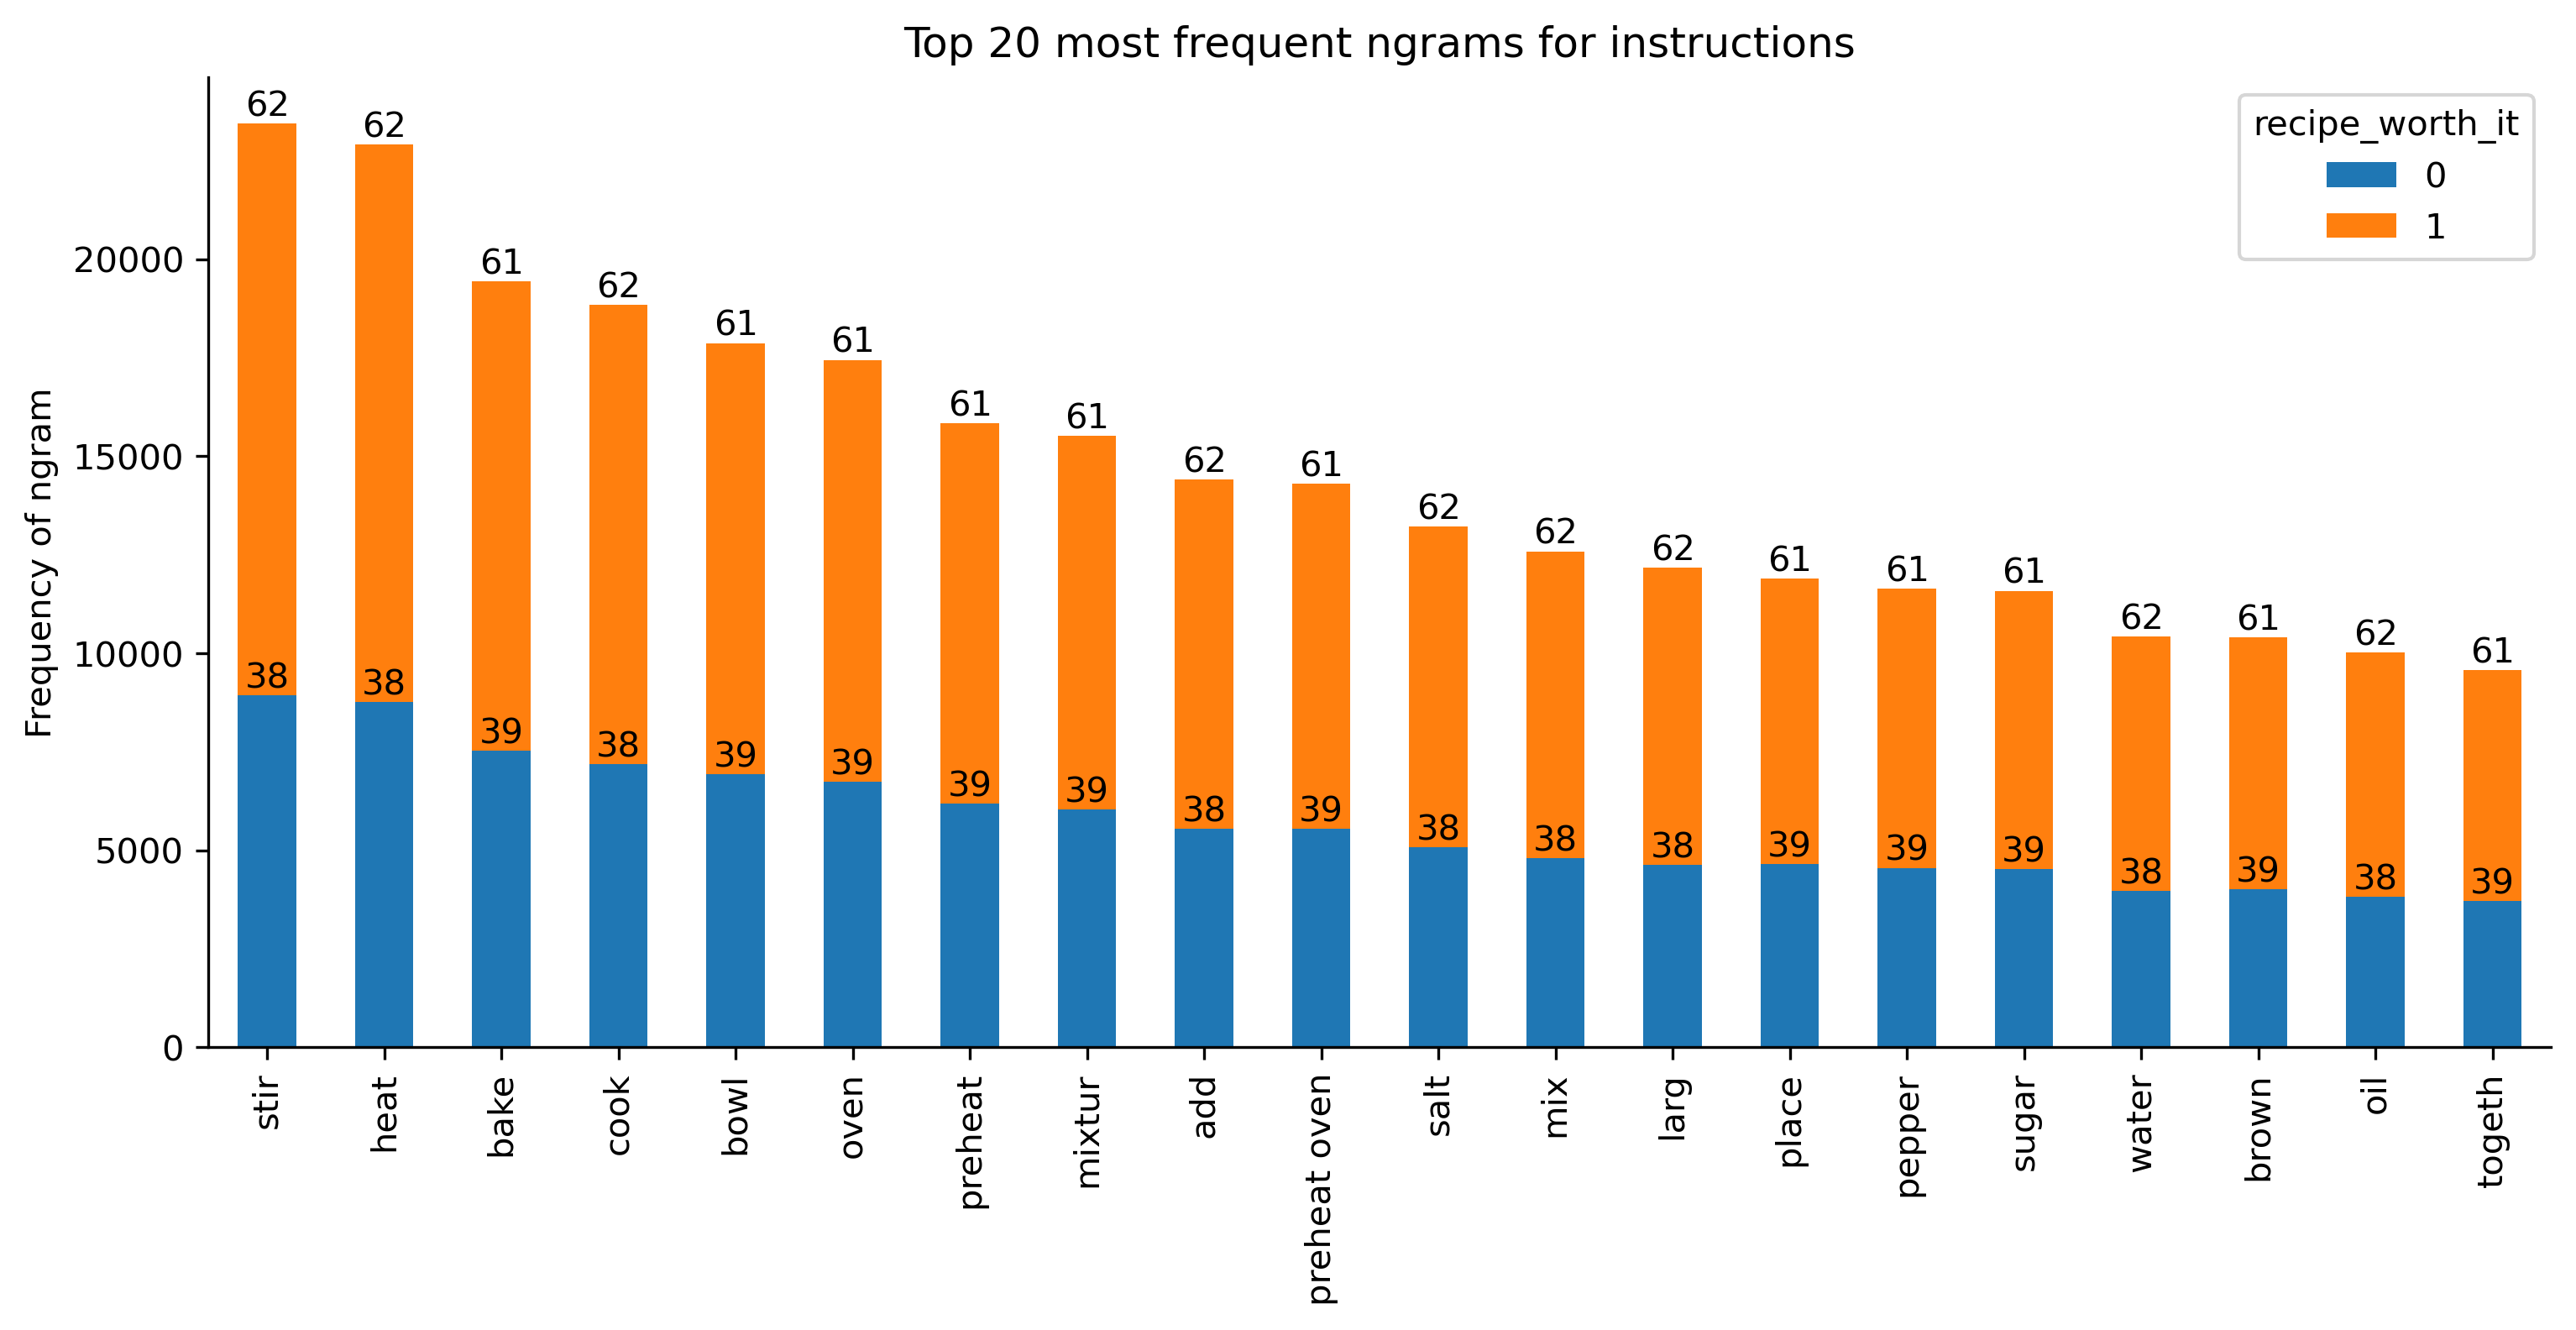

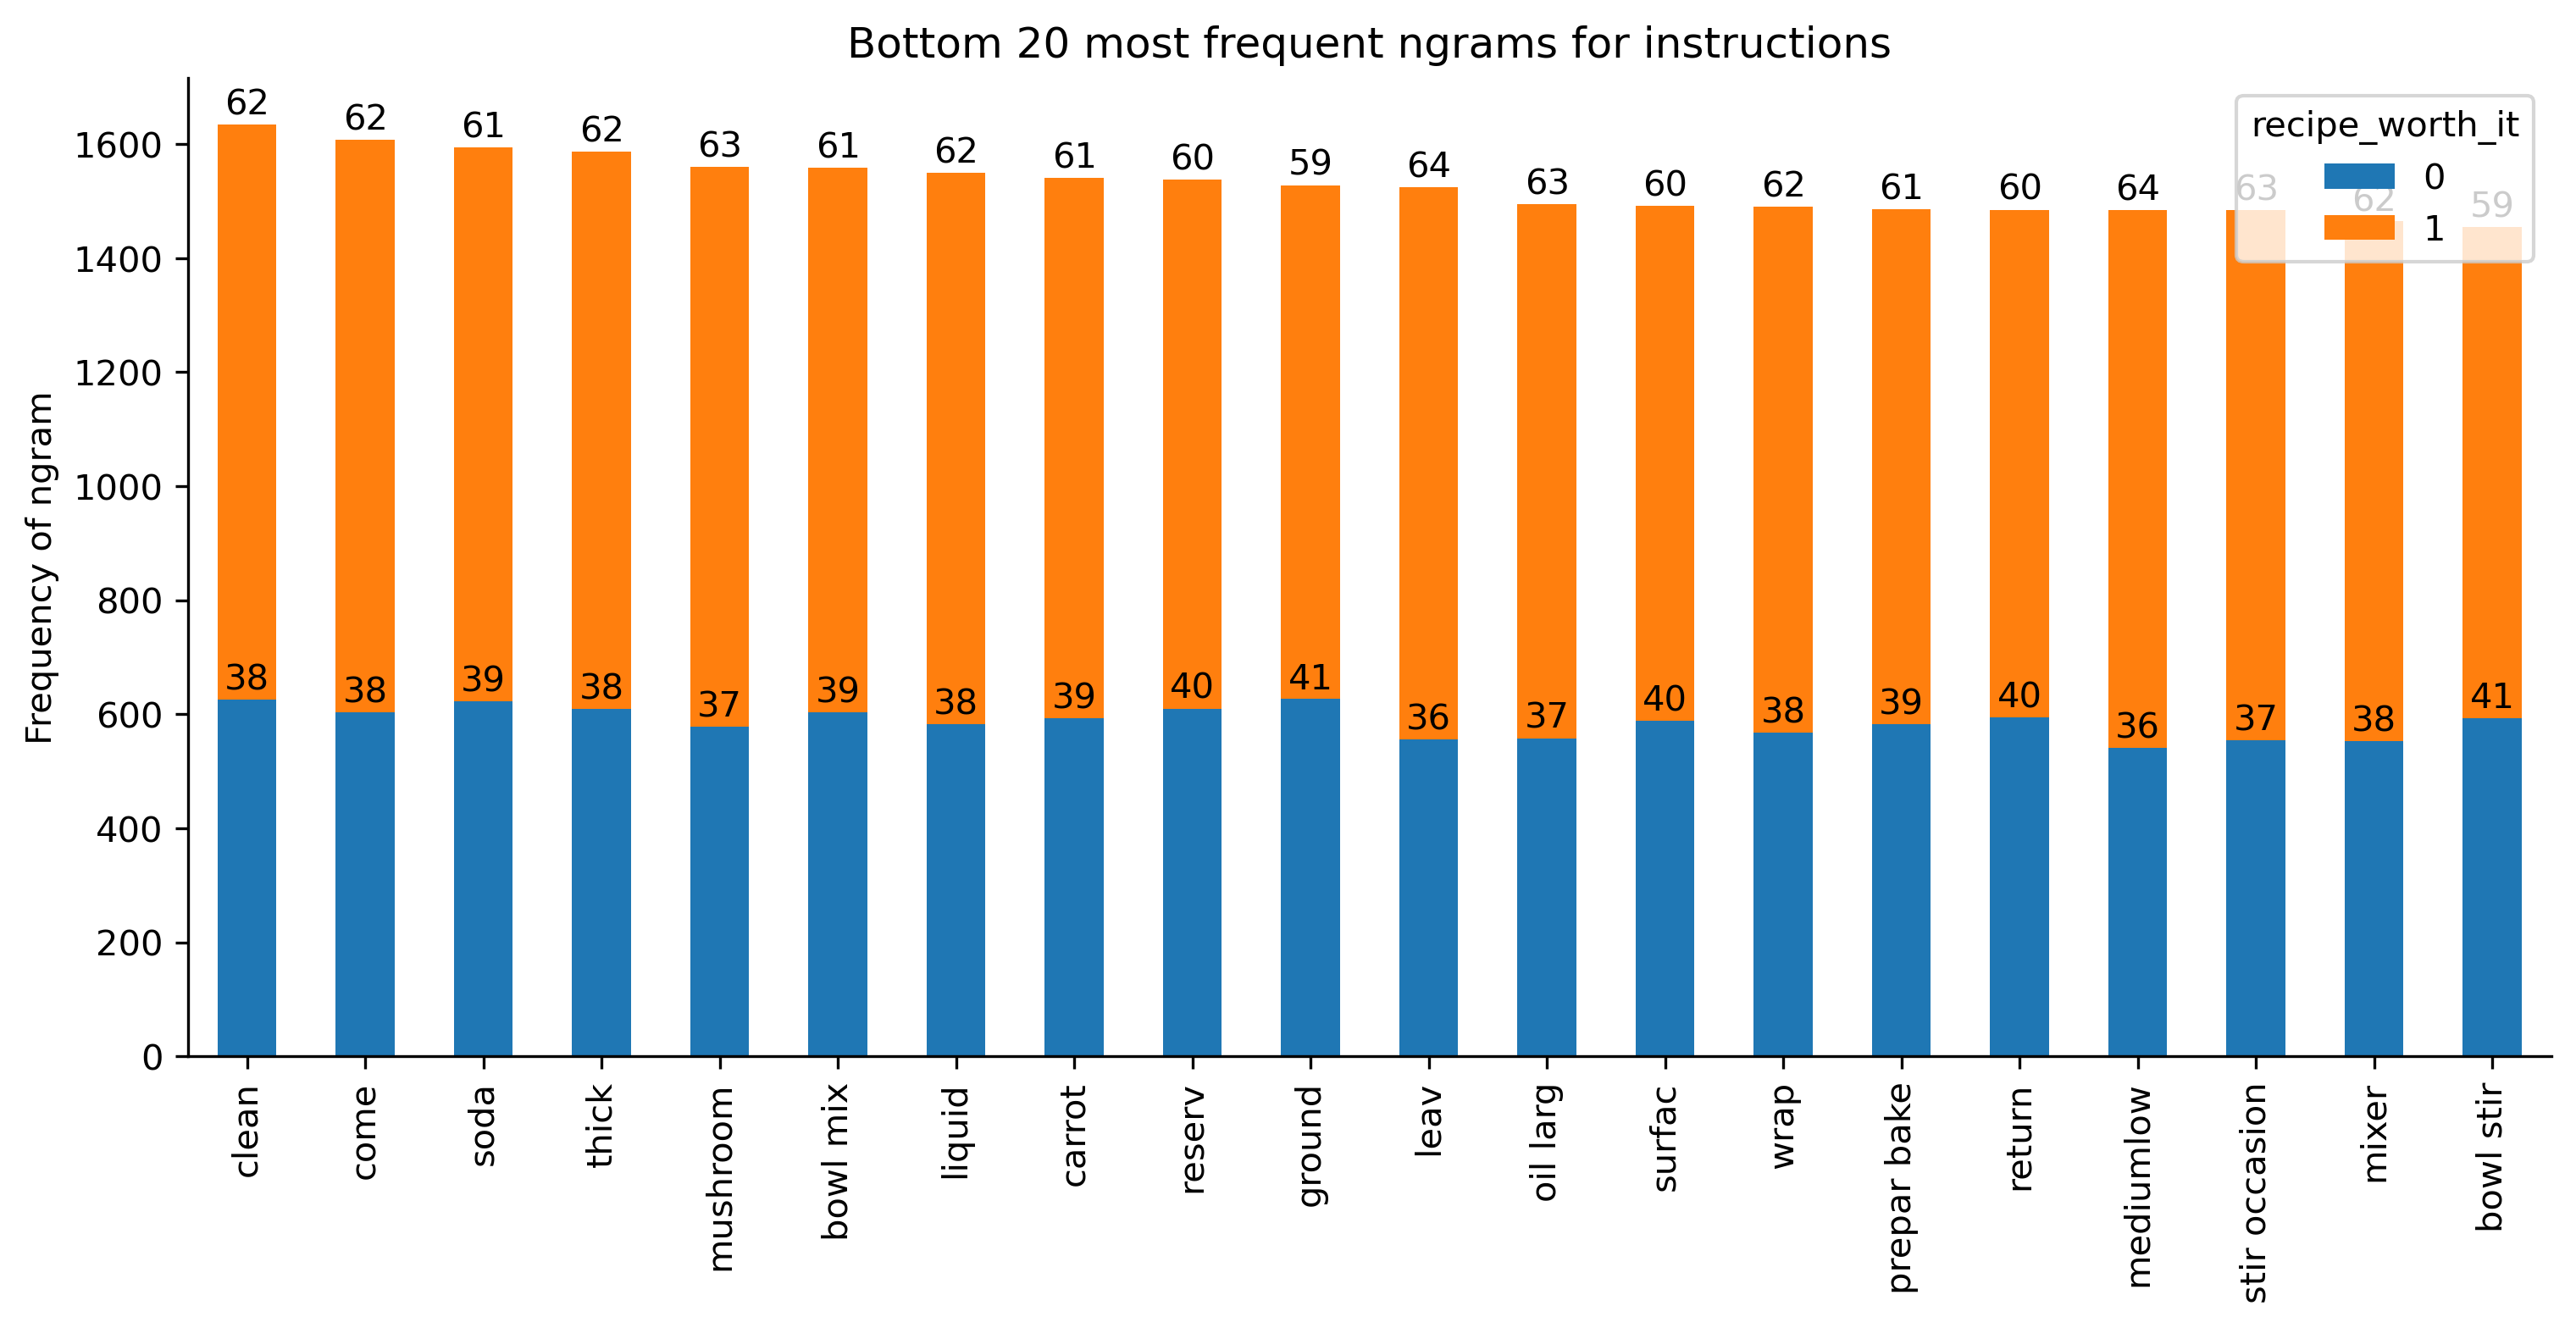



Time taken for CountVectorizer: 44.764 seconds.


In [445]:
# Initiate start time
start = time.perf_counter()

# Run a CountVectorizer on the 'instructions' column
count_vectorizer, ngram_count_df, vectorized_column = vectorizer(X_remainder, 'instructions', 0.05, (1,2), 200, y_remainder, 'count')

# Mark end time
end = time.perf_counter()
print(f"Time taken for CountVectorizer: {np.round(end-start,3)} seconds.")

========== FOR COLUMN: instructions ==========
Number of ngrams for instructions: 200
Parameters: min_df = 0.05, ngram_range = (1, 2), max_features = 200


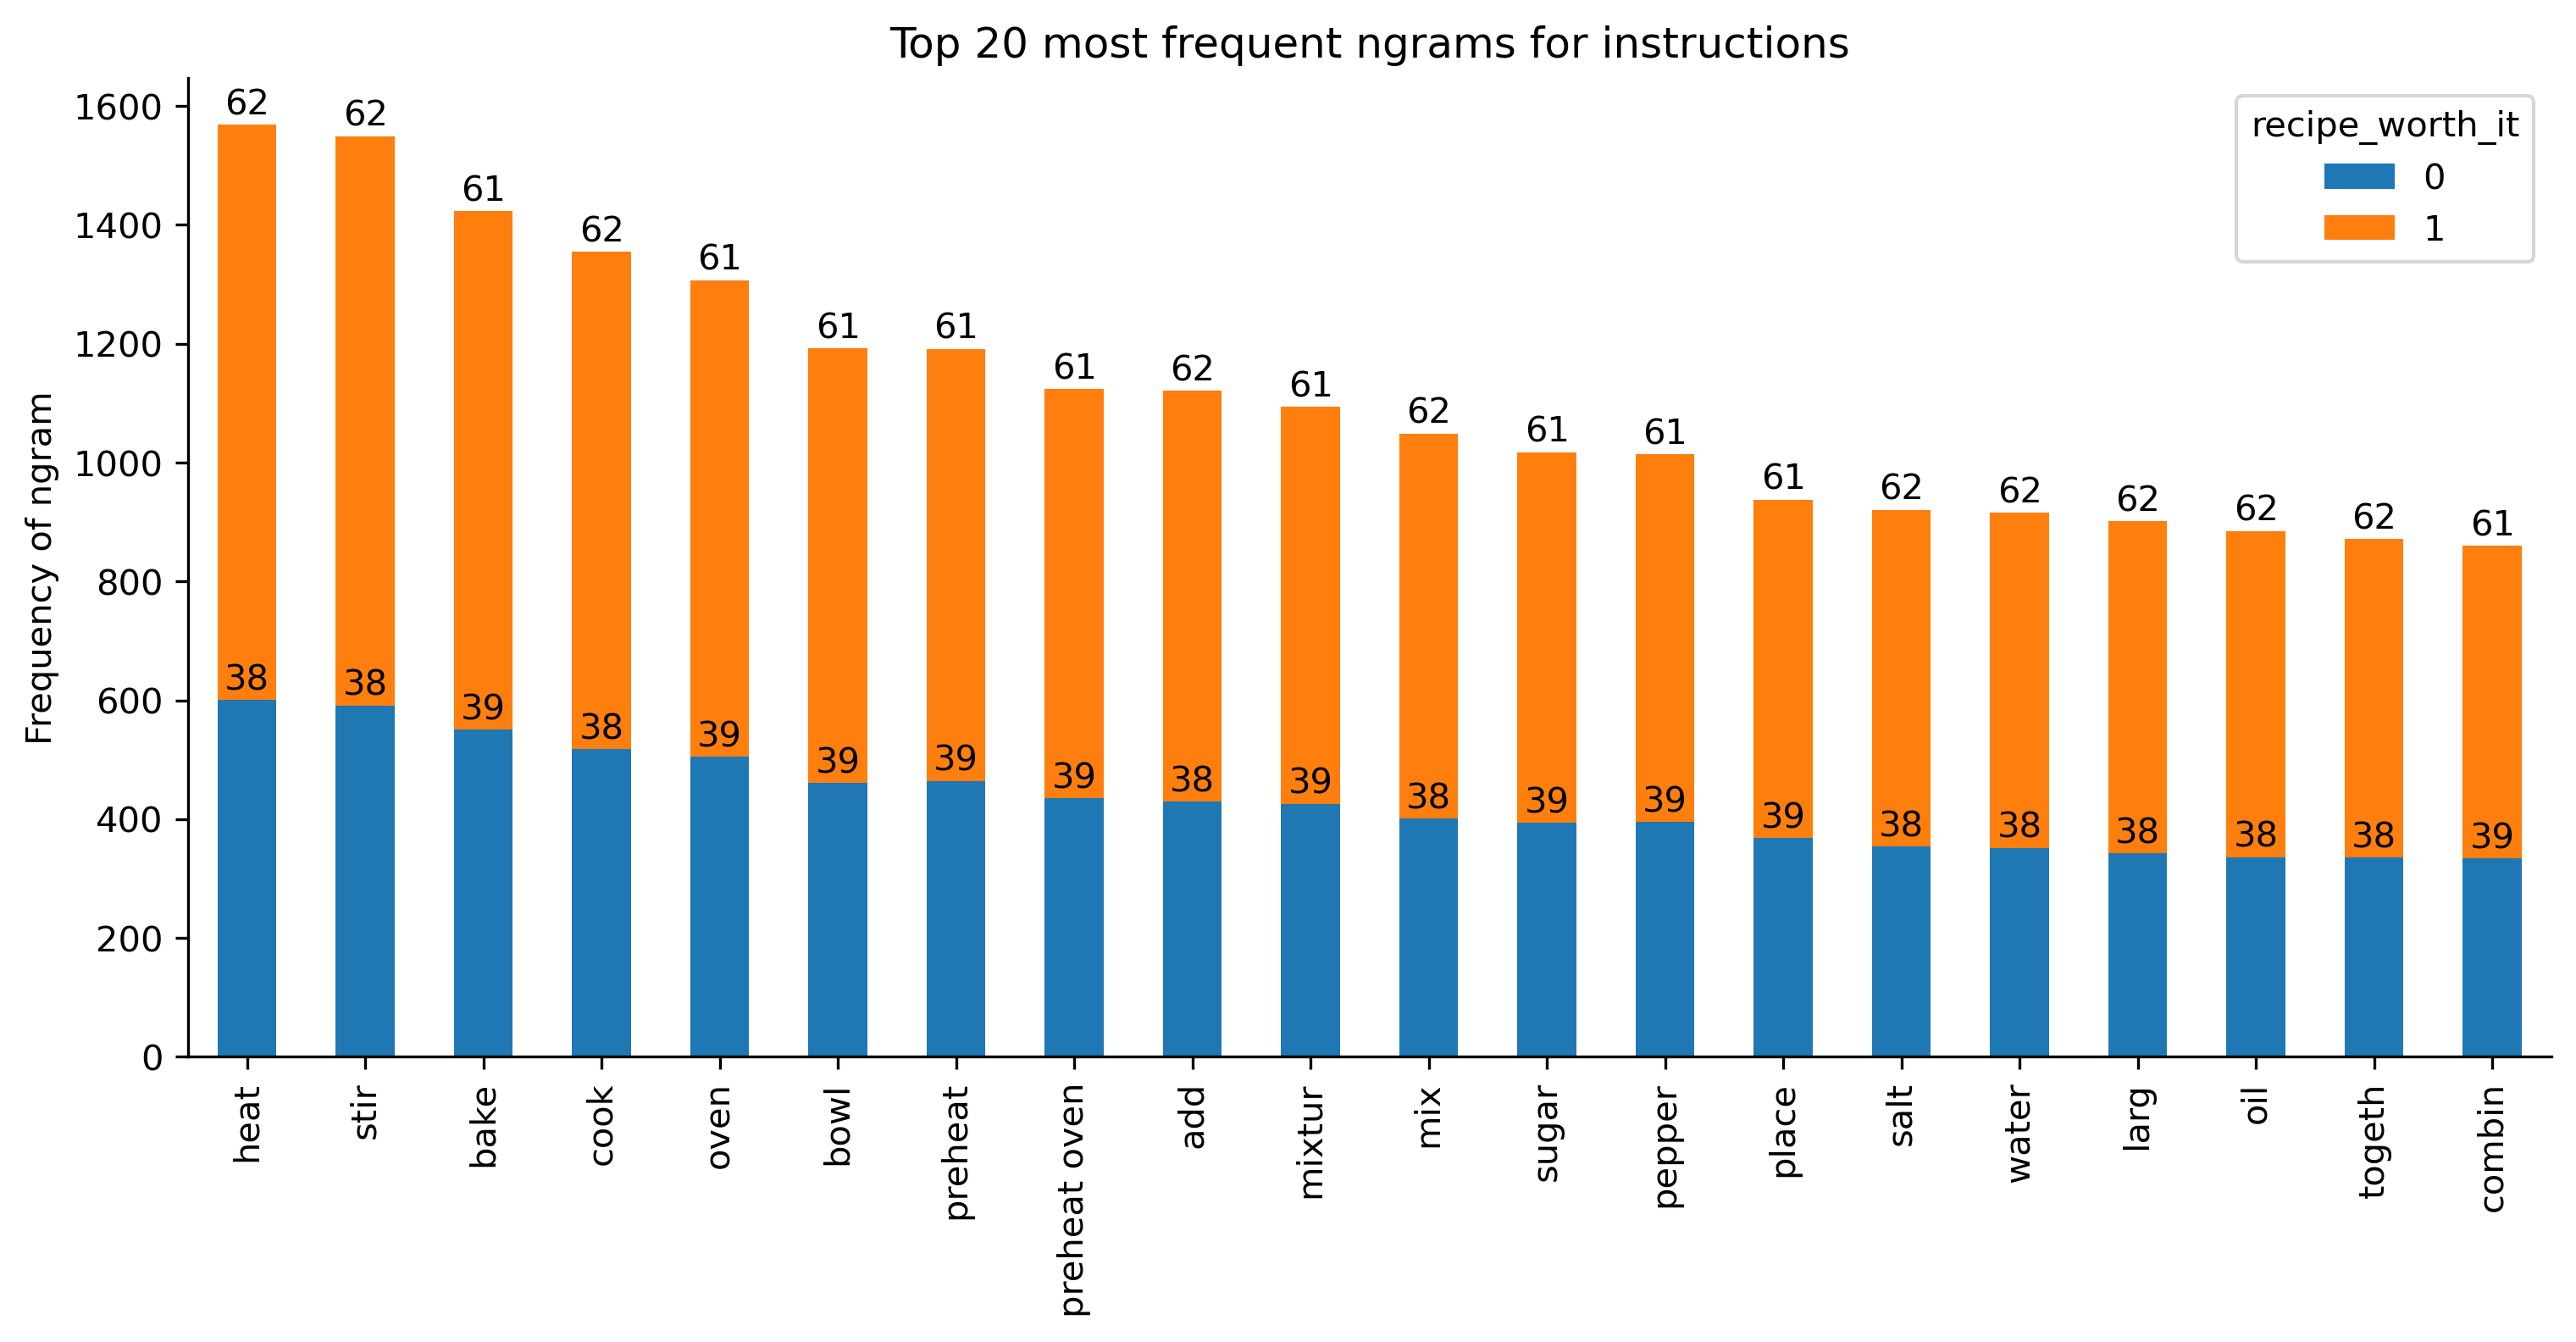

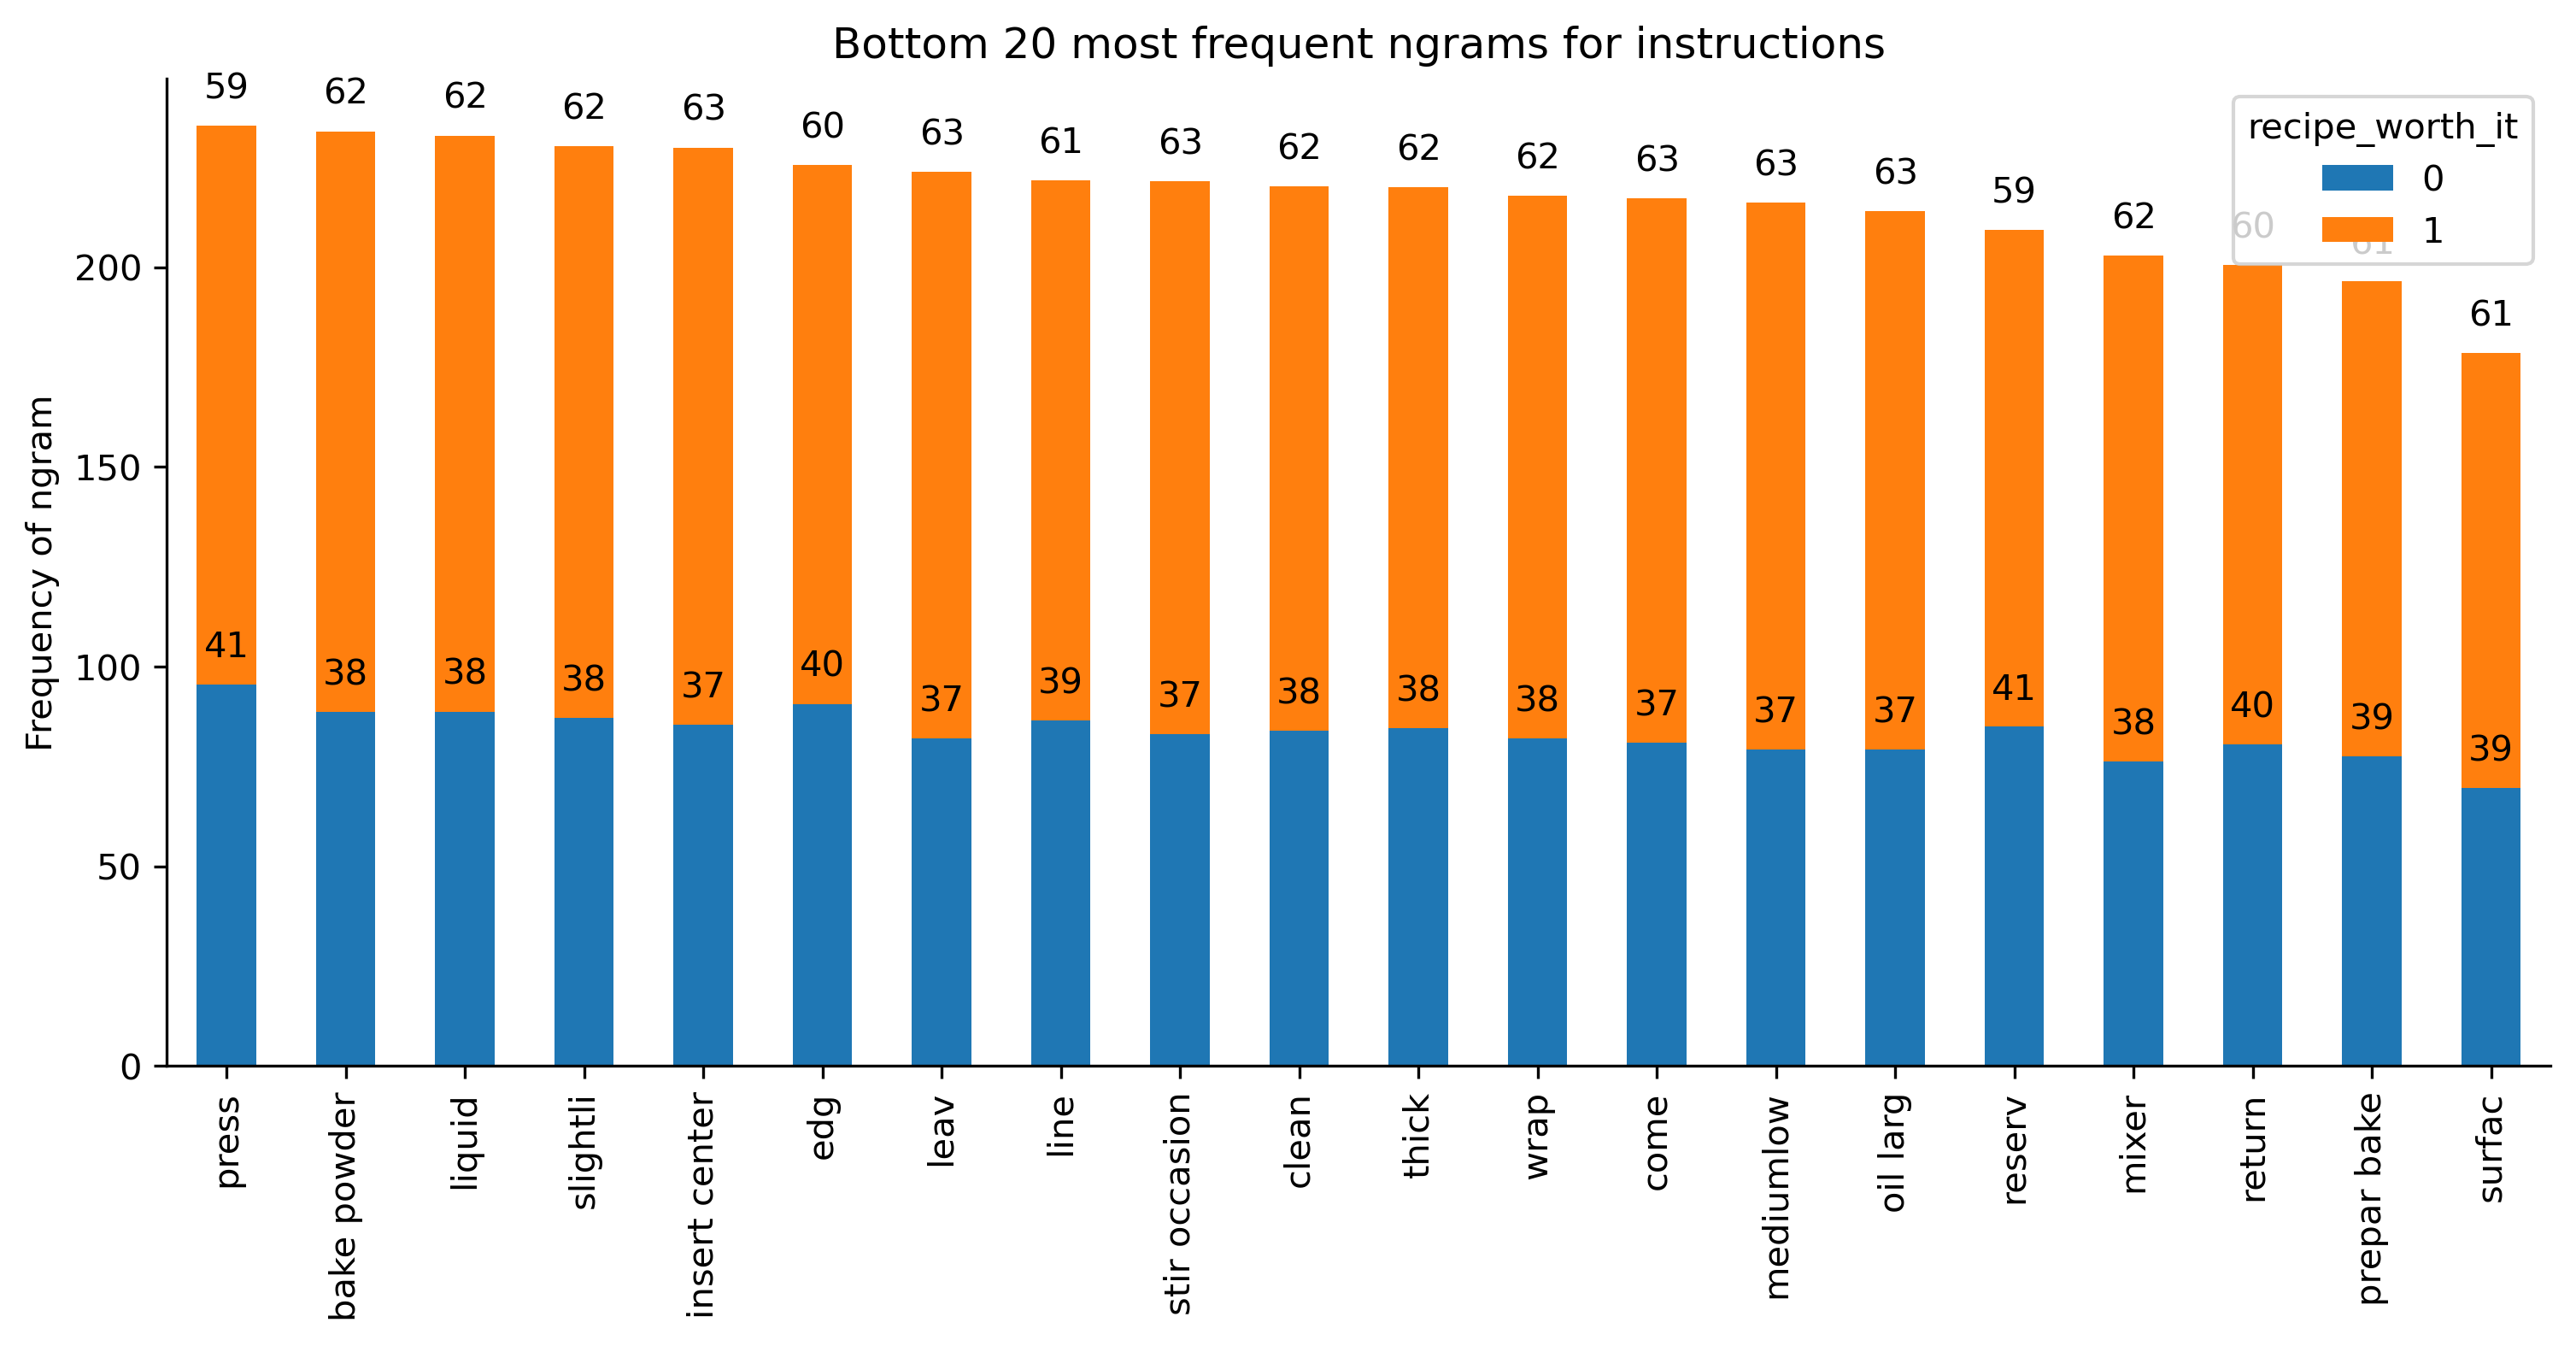



Time taken for TF-IDF: 44.597 seconds.


In [446]:
# Initiate start time
start = time.perf_counter()

# Run a TF-IDF vectorizer on the 'instructions' column
count_vectorizer, ngram_count_df, vectorized_column = vectorizer(X_remainder, 'instructions', 0.05, (1,2), 200, y_remainder, 'tfidf')

# Mark end time
end = time.perf_counter()
print(f"Time taken for TF-IDF: {np.round(end-start,3)} seconds.")

## TF-IDF settings

As a total of 8 text columns require a unique vectorizer for each column, the ColumnTransformer was used to perform 9 different TF-IDF vectorizations at the same time. The 8 text columns were split into two groups. The first group is `recipe_title` and `tags` which both have lesser word counts compared to the other text columns. As such, the min_df parameter was set at 0.01 to include any ngrams that appear in more than 1 % of the documents. The other group containing `description`, `instruction` and other longer text columns were set to use a min_df of 0.05 to reduce the number of ngrams. The max features for group 1 were set to 100 since less words should produce less ngrams while group 2 was set to 200 features. Finally, tthe ngram_range for both groups were set to 1 or 2 words to catch common verb + noun combinations in cooking, such as 'preheat oven' or 'stir wok'.

In [85]:
# Create the column transformer: preprocessing package + column to apply
col_transformations = [('pq_ohe', OneHotEncoder(drop = 'first'), ['published_quarter']),
                      
                       # recipe_title and tags are shorter text columns, thus min_df was set to 0.01 to include more ngrams
                       # max features were set to 100 to limit the number of features generated given these two columns are shorter text columns
                       ('rtxx', TfidfVectorizer(min_df = 0.01, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 100),'recipe_title'),
                      ('tags', TfidfVectorizer(min_df = 0.01, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 100),'tags'),
                       
                       # the other columns are much longer text columns, thus min_df was set to 0.05 to exclude more ngrams
                       # max features were set to 200 to limit the number of features created
                       ('dxxx', TfidfVectorizer(min_df = 0.05, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 200),'description'),
                      ('daxx', TfidfVectorizer(min_df = 0.05, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 200),'additional_description'),
                      ('dfxx', TfidfVectorizer(min_df = 0.05, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 200),'description_flavour_text'),
                      ('inst', TfidfVectorizer(min_df = 0.05, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 200),'instructions'),
                      ('ingr', TfidfVectorizer(min_df = 0.05, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 200),'ingredients'),
                      ('revx', TfidfVectorizer(min_df = 0.05, 
                                               max_df = 0.95, 
                                               tokenizer = my_tokenizer, 
                                               ngram_range = (1,2), 
                                               max_features = 200),'review')
                      ]

# Create the column transformer
col_transformer = ColumnTransformer(col_transformations)

# Fit the column transformer
col_transformer.fit(X_remainder);

In [86]:
# Initiate timer
start = time.perf_counter()

# Apply the transformations
transformed = col_transformer.transform(X_remainder) 

# Check the transformations
transformed_df = pd.DataFrame(transformed.todense(), columns=col_transformer.get_feature_names_out())
print(f"Transformed columns have {transformed_df.shape[0]} rows and {transformed_df.shape[1]} columns.")

end = time.perf_counter()
print(f"Time taken for column transformations: {np.round(end-start,3)} seconds.")

Transformed columns have 26952 rows and 1009 columns.
Time taken for column transformations: 716.948 seconds.


In [88]:
# Store fitted transformer as a pickle file
joblib.dump(col_transformer, 'model/col_transformer.pkl')

['model/col_transformer.pkl']

In [89]:
# Store transformed columns as a pickle file
joblib.dump(transformed_df, 'data_processed/transformed_df.pkl')

['data_processed/transformed_df.pkl']

## KNN Imputer

In [91]:
# Condition to identify only columns with null values
cond1 = X_remainder.columns[X_remainder.isna().any()]

# Examining the percentage of null values in each column
display(X_remainder[cond1].isna().sum() / X_remainder.shape[0] * 100)

calories_kcal             1.639953
carbohydrateContent_g     1.758682
cholesterolContent_mg    18.139656
fiberContent_g            5.417038
proteinContent_g          2.326358
saturatedFatContent_g     6.433660
sodiumContent_mg          1.703028
sugarContent_g            5.780647
number_of_servings        0.037103
cook_time                 5.724993
prep_time                 5.724993
total_time                5.724993
dtype: float64

In [92]:
cond_null_total_time = X_remainder['total_time'].isna()
cond_null_cholesterol = X_remainder['cholesterolContent_mg'].isna()

In [93]:
X_remainder.describe()

,recipe_title_wc,number_of_ratings,description_wc,additional_description_wc,description_flavour_text_wc,instructions_with_image,number_of_ingredients,calories_kcal,carbohydrateContent_g,cholesterolContent_mg,...,proteinContent_g,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,number_of_servings,cook_time,prep_time,total_time,published_quarter,wc_per_instruction
count,26952.000000,26952.000000,26952.000000,26952.000000,26952.000000,26952.000000,26952.000000,26510.000000,26478.000000,22063.000000,...,26325.000000,25218.000000,26493.000000,25394.000000,26942.000000,25409.000000,25409.000000,25409.000000,26952.000000,26952.000000
mean,3.787993,151.141696,31.263654,130.992431,23.656946,0.158504,9.412622,324.317276,31.097930,72.958845,...,13.574511,6.707629,579.341335,12.738915,10.992651,82.824354,18.320123,166.129954,2.144294,30.691185
std,1.466869,533.839261,18.629732,105.009689,8.487057,0.365220,4.014344,213.890603,23.853965,72.650924,...,14.674270,6.500607,1302.880647,15.527754,13.086301,1297.447288,61.470920,1502.533919,0.884101,11.537343
min,1.000000,2.000000,1.000000,9.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000
25%,3.000000,9.000000,18.000000,72.000000,19.000000,0.000000,6.000000,173.000000,13.000000,23.000000,...,3.000000,2.000000,145.000000,3.000000,4.000000,10.000000,10.000000,30.000000,2.000000,22.750000
50%,4.000000,32.000000,27.000000,107.000000,23.000000,0.000000,9.000000,288.000000,27.000000,54.000000,...,8.000000,5.000000,350.000000,7.000000,8.000000,25.000000,15.000000,55.000000,2.000000,28.666667
75%,5.000000,108.000000,41.000000,155.000000,26.000000,0.000000,12.000000,431.000000,43.000000,98.000000,...,21.000000,9.000000,757.000000,18.000000,12.000000,50.000000,20.000000,95.000000,2.000000,36.333333
max,20.000000,19961.000000,143.000000,1354.000000,111.000000,1.000000,33.000000,4709.000000,622.000000,1332.000000,...,519.000000,103.000000,114785.000000,575.000000,472.000000,172800.000000,7200.000000,172820.000000,4.000000,124.000000


To prevent data leakage during cross validation, text vectorization and imputation should ideally be included as part of the GridSearchCV pipeline. However, for this study, as the TF-IDF vectorizer required 716.948 seconds to run, KNN imputation was implemented outside the GridSearchCV pipeline to reduce the time for GridSearchCV to a practical level. Furthermore, as the KNN imputer depends on the values of other columns to impute null values, a test was carried out to determine the difference in imputation between including and excluding TF-IDF vectorized columns.

In [126]:
# CASE 1: Exclude TF-IDF vectorized columns
# Start timer
start = time.perf_counter()

# Initiate imputer
imputer = KNNImputer()

# Fit imputer to X_remainder, then 
X_remainder_copy = imputer.fit_transform(X_remainder.select_dtypes('number'))

# End timer
end = time.perf_counter()
print(f"Time taken to impute null values : {np.round(end - start,3)}.")

Time taken to impute null values : 24.776.


In [105]:
# CASE 2: Include TF-IDF vectorized columns
# Create a copy of the DataFrame for testing imputation using numerical columns + vectorized text columns
X_remainder2 = X_remainder.select_dtypes('number').copy()

# Dropping published quarter since it was already one hot encoded
X_remainder2.drop(columns = 'published_quarter', inplace = True)

# Joining the Column Transformed DataFrame with the copy to prepare for imputation
X_remainder2 = pd.concat([X_remainder2,transformed_df], axis = 1)

# Start timer
start = time.perf_counter()

# Initiate imputer
imputer = KNNImputer()

# Fit imputer to X_remainder, then 
X_remainder2_copy = imputer.fit_transform(X_remainder2)

# End timer
end = time.perf_counter()
print(f"Time taken to impute null values : {np.round(end - start,3)}.")

Time taken to impute null values : 530.039.


In [127]:
# Combine the column 'choleterolContent_mg' from the original with nulls, CASE1, and CASE2
evaluate_null_df = pd.concat([X_remainder[['cholesterolContent_mg']],
                              pd.DataFrame(X_remainder_copy).iloc[:,9],
                              pd.DataFrame(X_remainder2_copy).iloc[:,9]
                             ], axis = 1)

# Examine the first 5 rows to ensure the join happened correctly
evaluate_null_df.columns = ['original', 'CASE1', 'CASE2']
evaluate_null_df.head()

,original,CASE1,CASE2
0,31.0,31.0,31.0
1,NaN,7.0,5.4
2,NaN,17.6,17.6
3,115.0,115.0,115.0
4,21.0,21.0,21.0


In [128]:
# Examine summary statistics of imputed columns
evaluate_null_df.describe()

,original,CASE1,CASE2
count,22063.000000,26952.000000,26952.000000
mean,72.958845,66.025794,66.034061
std,72.650924,68.543769,68.525472
min,0.000000,0.000000,0.000000
25%,23.000000,20.000000,20.000000
50%,54.000000,47.000000,47.000000
75%,98.000000,89.000000,89.000000
max,1332.000000,1332.000000,1332.000000


===== Distribution Plots for original =====


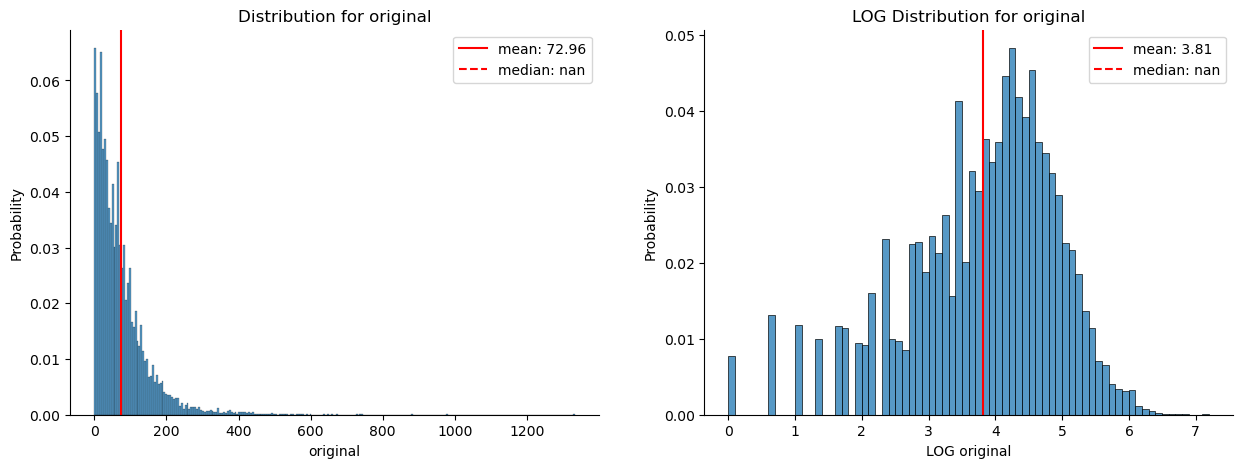

Time taken : 1.614 seconds.


===== Distribution Plots for CASE1 =====


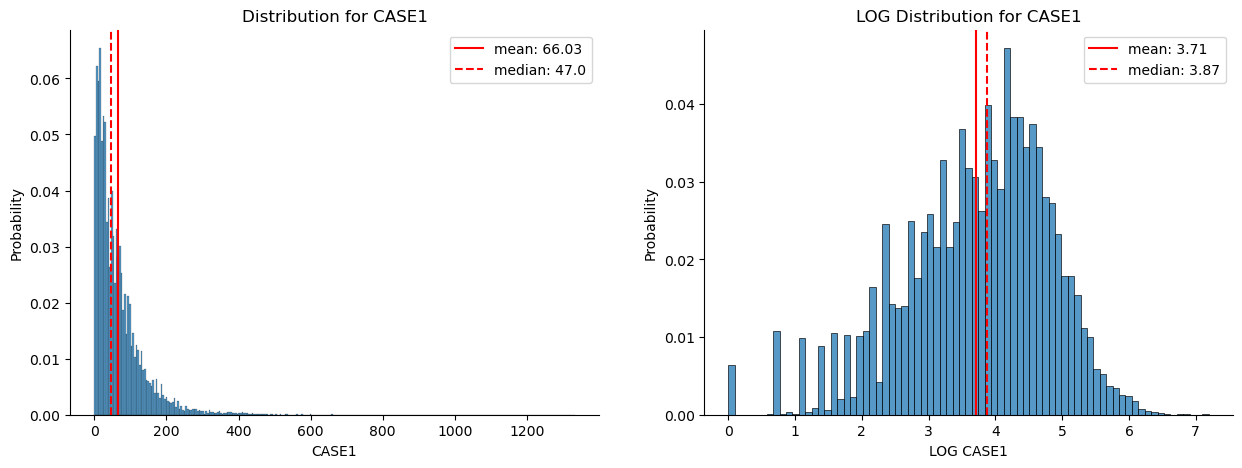

Time taken : 0.976 seconds.


===== Distribution Plots for CASE2 =====


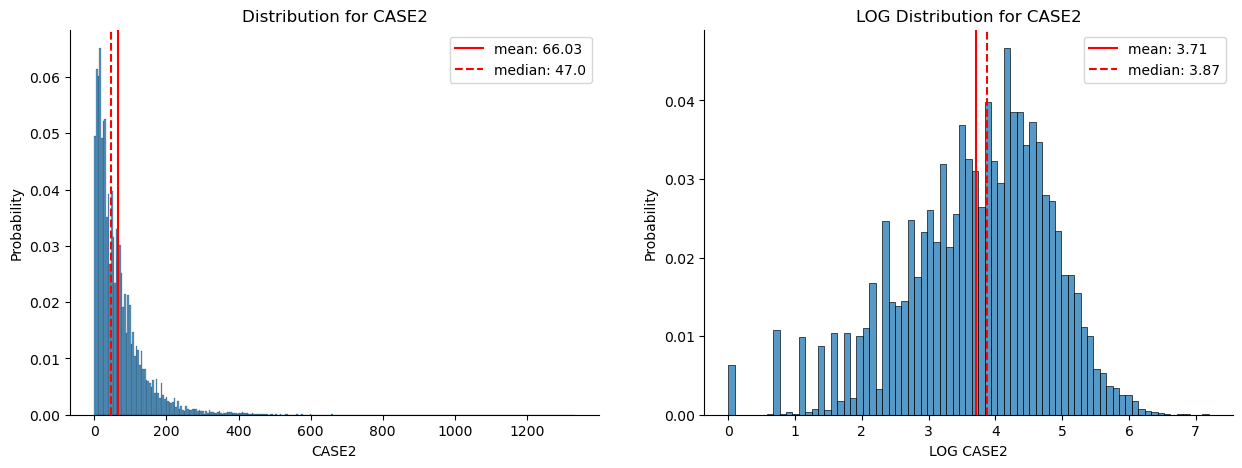

Time taken : 0.962 seconds.




In [129]:
# Visually examine distribution of imputed columns
for col in evaluate_null_df.columns.to_list():
    plot_distribution(evaluate_null_df,col)

After testing, the KNN imputer was observed to generate approximately the same results both numerically and visually regardless of TF-IDF vectorized columns. As an example, the distributions of the column with the most null values, 'cholesterolContent_mg' was preserved using KNN imputer in the above images. Most importantly, the KNN imputer took 23.706 seconds without the TF-IDF vectorized columns and 530.039 seconds with the vectorized columns. Thus, the KNN imputer was implemented without the TF-IDF vectorized columns to keep computation time to a minimum while achieving the same results.

## Application of Final Preprocessing

In [139]:
# Apply OHE and TF-IDF vectorizer using Column Transformer
# Initiate timer
start = time.perf_counter()

print(f"Shape at start: {X_remainder.shape}")

# Apply KNN imputer
num_df = X_remainder.select_dtypes(include = 'number')
tex_df = X_remainder.select_dtypes(exclude = 'number')
num_df_tf =  pd.DataFrame(imputer.transform(num_df),
                          columns = num_df.columns.to_list())
X_remainder_t = pd.concat([num_df_tf, tex_df], axis = 1)

print(f"Shape after KNN imputer: {X_remainder_t.shape}")

# Apply the ColumnTransformer
transformed = col_transformer.transform(X_remainder_t) 
transformed_df = pd.DataFrame(transformed.todense(), 
                              columns=col_transformer.get_feature_names_out())
X_remainder_t = pd.concat([X_remainder_t, transformed_df], axis = 1)

print(f"Shape after ColumnTransformer: {X_remainder_t.shape}")

# Dropping vectorized columns
X_remainder_t = X_remainder_t.select_dtypes('number').copy()
X_remainder_t.drop(columns = ['published_quarter'], inplace = True)
print(f"Shape after dropping vectorized columns: {X_remainder_t.shape}")

print(f"Checking for null values: {X_remainder_t.isna().sum().sum()}.")
print(f"Checking shape of numerical columns:{X_remainder_t.select_dtypes('number').shape}")


end = time.perf_counter()
print(f"Time taken for column transformations: {np.round(end-start,3)} seconds.")

Shape at start: (26952, 29)
Shape after KNN imputer: (26952, 29)
Shape after ColumnTransformer: (26952, 1038)
Shape after dropping vectorized columns: (26952, 1029)
Checking for null values: 0.
Checking shape of numerical columns:(26952, 1029)
Time taken for column transformations: 754.61 seconds.


# Modelling

<u>**GENERAL PROCEDURE FOR MODEL TRAINING OUTSIDE CROSS VALIDATION AND GRIDSEARCH**</u>

Before optimizing any hyperparameters using cross validation and grid search, simple models were fitted first to better understand the base performance of the models. The following procedures were applied to each model that did not use cross validation or grid search:
1. Split remainder data into train and validation (no cross validation at this stage)
2. Take the LOG of train data
3. Apply standard scale to the train data
4. Fit model with default hyperparameters.
5. Determine accuracy with precision and recall for class one on validation sets.
<br>
<br>
<br>

After first round with default parameters, hyperparameter tuning was performed using GridSearchCV and Pipelines for the final models. To this end, the remainder data (train + validation) was used for croass validation:
- For best model, examine precision recall.
- For best model and if applicable, examine coefficients.
- For final model decided, apply to test data with no more changes allowed.

## Split Remainder Data into Train and Validation

In [319]:
# Split data into train and validation
X_train_t, X_val_t, y_train, y_val = train_test_split(X_remainder_t,
                                                          y_remainder,
                                                          test_size = 0.2,
                                                          stratify = y_remainder,
                                                          random_state = rs)

In [320]:
print(f"For X_train_t:")
print(f"The independent features have {X_train_t.shape[0]} rows and {X_train_t.shape[1]} columns.")
print(f"The target feature has {y_train.shape[0]} rows.")
print(f"Checking proportions of target feature:")
print(y_train.value_counts(normalize = True))

For X_train_t:
The independent features have 21561 rows and 1029 columns.
The target feature has 21561 rows.
Checking proportions of target feature:
1    0.584806
0    0.415194
Name: recipe_worth_it, dtype: float64


In [321]:
print(f"For X_val_t:")
print(f"The independent features have {X_val_t.shape[0]} rows and {X_val_t.shape[1]} columns.")
print(f"The target feature has {y_val.shape[0]} rows.")
print(f"Checking proportions of target feature:")
print(y_val.value_counts(normalize = True))

For X_val_t:
The independent features have 5391 rows and 1029 columns.
The target feature has 5391 rows.
Checking proportions of target feature:
1    0.584864
0    0.415136
Name: recipe_worth_it, dtype: float64


Train test split was observed to split the data while preserving the proportions of the target variable among the split data sets. The data was then used for modelling.

## Base Model with Default Parameter Testing

### Logistic Regression

In [322]:
# Apply log to deal with outliers and skew of data
X_train_tl = np.log(X_train_t+1)

# Apply standard scaler to ease convergence of logistic regression function
scaler = StandardScaler()
X_train_tls = scaler.fit_transform(X_train_tl)

# Apply the same transformation to 
X_val_tl = np.log(X_val_t+1)
X_val_tls = scaler.transform(X_val_tl)

In [323]:
# Fit the basic logistic regression model
model_lr0 = base_model_fit(X_train_tls,
                           y_train, 
                           X_val_tls, 
                           y_val, 
                           LogisticRegression(solver = 'lbfgs',
                                              random_state = rs,
                                              max_iter = 10000))

Base fitting of a LogisticRegression(max_iter=10000, random_state=42) with no hyperparameter adjustment.
Accuracy for train data: 78.58%
Accuracy for validation data: 76.03%
Time taken:9.7927 seconds


model_lr0: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2238
           1       0.78      0.82      0.80      3153

    accuracy                           0.76      5391
   macro avg       0.75      0.75      0.75      5391
weighted avg       0.76      0.76      0.76      5391



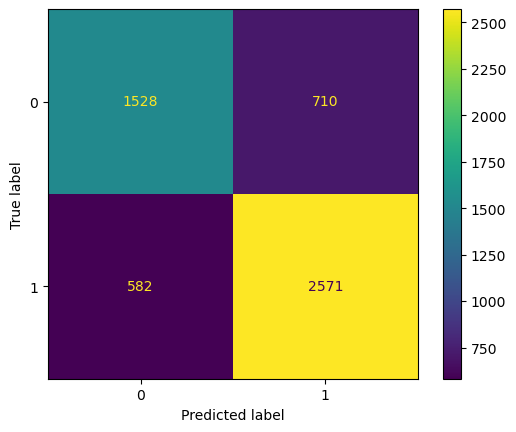

In [156]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_tls, y_val, model_lr0,'model_lr0')

| model name | hyperparameters                          | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler    | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |

The basic logistic regression outperformed the base line by almost 20%.

### K-Nearest Neighbour (KNN)

In [294]:
# Fitting the basic model with default parameters
model_knn0 = base_model_fit(X_train_tls,
                            y_train, 
                            X_val_tls, 
                            y_val, 
                            KNeighborsClassifier())

Base fitting of a KNeighborsClassifier() with no hyperparameter adjustment.
Accuracy for train data: 74.41%
Accuracy for validation data: 61.57%
Time taken:18.2876 seconds


model_lr0: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.55      0.38      0.45      2238
           1       0.64      0.78      0.70      3153

    accuracy                           0.62      5391
   macro avg       0.60      0.58      0.58      5391
weighted avg       0.60      0.62      0.60      5391



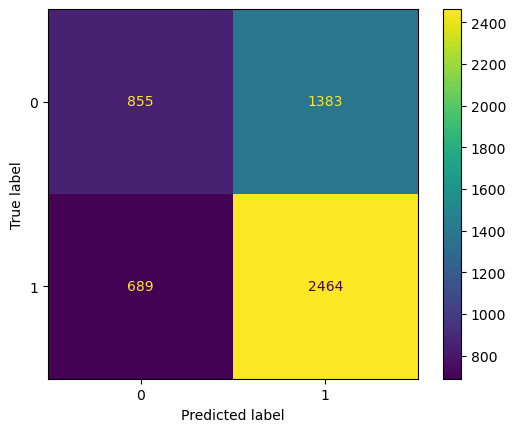

In [295]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_tls, y_val, model_knn0, 'model_knn0')

| model name | hyperparameters                          | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler    | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |
| model_knn0 | default, no PCA, log, standard scaler    | 74.41%             | 61.57%                  | 0.64                              | 0.78                          | 18.29                  |

The basic KNN model performed poorly in all aspects compared to logistic regression. Specifically, the amount of overfit for KNN was higher compared to logistic expression (2% difference between train and validation for logistic regression while 13% difference for KNN). Furthermore, both the precision and recall of the `worth it` class was poorer for KNN.

### Random Forest Classifier

In [298]:
# Fitting the basic model with default parameters
model_rf0 = base_model_fit(X_train_t,
                           y_train, 
                           X_val_t, 
                           y_val, 
                           RandomForestClassifier())

Base fitting of a RandomForestClassifier() with no hyperparameter adjustment.
Accuracy for train data: 100.0%
Accuracy for validation data: 73.77%
Time taken:22.3467 seconds


model_lr0: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.78      0.51      0.62      2238
           1       0.72      0.90      0.80      3153

    accuracy                           0.74      5391
   macro avg       0.75      0.71      0.71      5391
weighted avg       0.75      0.74      0.73      5391



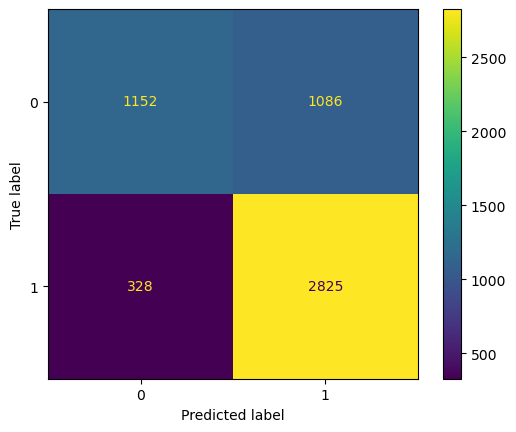

In [299]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_t, y_val, model_rf0, 'model_rf0')

| model name | hyperparameters                          | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler    | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |
| model_knn0 | default, no PCA, log, standard scaler    | 74.41%             | 61.57%                  | 0.64                              | 0.78                          | 18.29                  |
| model_rf0  | default, no PCA                          | 100.00%            | 73.77%                  | 0.72                              | 0.90                          | 22.35                  |


As Random Forests are just an average of many Decision Trees, and Decision Trees do not benefit from scaling, the data was fed into the Random Forest base model without taking the log or going through a standard scaler. Compared to the previous models, the random forest model was severely overfitted with a train accuracy of 100%. Overall, the performance of the random forest model was slightly poorer tthan logistic regression but better than KNN. Also, the Random Forest model took the most time among the models so far.

### Gradient Boosting

In [300]:
# Fitting the basic model with default parameters
model_gb0 = base_model_fit(X_train_t,
                           y_train, 
                           X_val_t, 
                           y_val, 
                           GradientBoostingClassifier())

Base fitting of a GradientBoostingClassifier() with no hyperparameter adjustment.
Accuracy for train data: 78.45%
Accuracy for validation data: 75.64%
Time taken:154.6127 seconds


model_lr0: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.75      0.62      0.68      2238
           1       0.76      0.85      0.80      3153

    accuracy                           0.76      5391
   macro avg       0.75      0.74      0.74      5391
weighted avg       0.76      0.76      0.75      5391



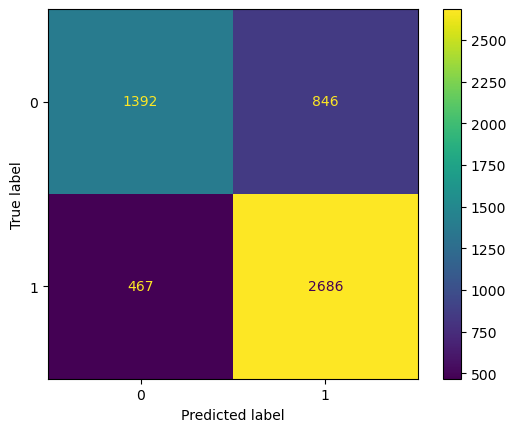

In [305]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_t, y_val, model_gb0, 'model_gb0')

| model name | hyperparameters                          | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler    | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |
| model_knn0 | default, no PCA, log, standard scaler    | 74.41%             | 61.57%                  | 0.64                              | 0.78                          | 18.29                  |
| model_rf0  | default, no PCA                          | 100.00%            | 73.77%                  | 0.72                              | 0.90                          | 22.35                  |
| model_gb0  | default, no PCA                          | 78.45%             | 75.64%                  | 0.76                              | 0.85                          | 154.61                 |

Compared to the Random Forest model, the Gradient Boosting model presented less overfitting with performance similar to logistic regression. However, the time taken to train the Gradient Boosting model was the longest among the models so far at 154.61 seconds.

### XGBoost

Given XGBoost is more powerful compared to the other two ensemble methods tested and is also based on decision trees, a test was carried out to verify if taking the log and applying standard scaler makes a difference.
- CASE1: no log and no standard scaler
- CASE2: log but no standard scaler
- CASE3: log with standard scaler
- CASE4: no log but standard scaler

#### CASE1: no log and no standard scaler

In [302]:
# Fitting the basic model with default parameters
model_xg0 = base_model_fit(X_train_t,
                           y_train, 
                           X_val_t, 
                           y_val, 
                           XGBClassifier())

Base fitting of a XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) with no hyperparameter adjustment.
Accuracy for train data: 97.95%
Accuracy for validation data: 75.46%
Time taken:44.7821 seconds


model_xg0: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2238
           1       0.77      0.83      0.80      3153

    accuracy                           0.75      5391
   macro avg       0.75      0.74      0.74      5391
weighted avg       0.75      0.75      0.75      5391



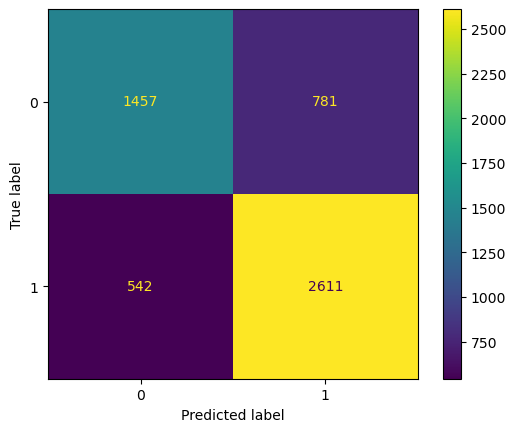

In [310]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_t, y_val, model_xg0,'model_xg0')

#### CASE2: log but no standard scaler

In [311]:
# Fitting the basic model with default parameters
model_xg1 = base_model_fit(X_train_tl,
                           y_train, 
                           X_val_tl, 
                           y_val, 
                           XGBClassifier())

Base fitting of a XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) with no hyperparameter adjustment.
Accuracy for train data: 97.95%
Accuracy for validation data: 75.46%
Time taken:45.1635 seconds


model_xg1: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2238
           1       0.77      0.83      0.80      3153

    accuracy                           0.75      5391
   macro avg       0.75      0.74      0.74      5391
weighted avg       0.75      0.75      0.75      5391



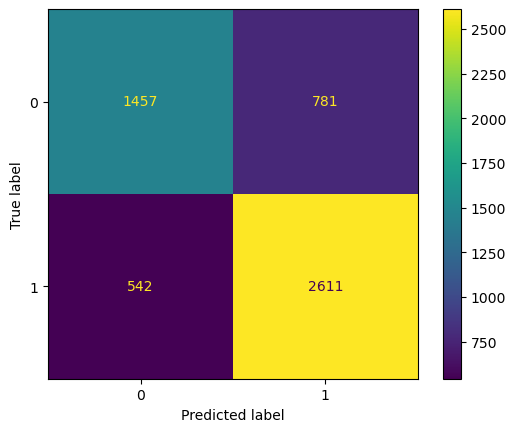

In [318]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_tl, y_val, model_xg1,'model_xg1')

#### CASE3: log with standard scaler

In [313]:
# Fitting the basic model with default parameters
model_xg2 = base_model_fit(X_train_tls,
                           y_train, 
                           X_val_tls, 
                           y_val, 
                           XGBClassifier())

Base fitting of a XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) with no hyperparameter adjustment.
Accuracy for train data: 97.95%
Accuracy for validation data: 75.46%
Time taken:44.9039 seconds


model_xg2: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2238
           1       0.77      0.83      0.80      3153

    accuracy                           0.75      5391
   macro avg       0.75      0.74      0.74      5391
weighted avg       0.75      0.75      0.75      5391



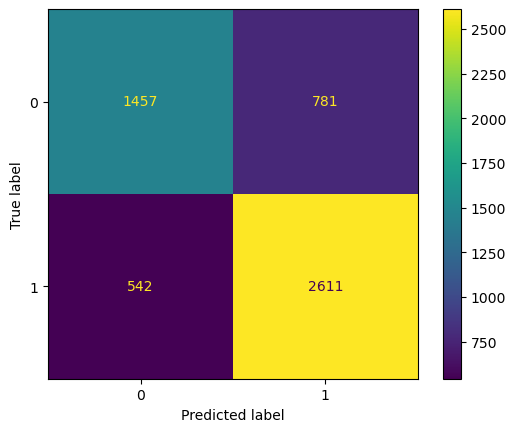

In [317]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_tls, y_val, model_xg2,'model_xg2')

#### CASE4: no log but standard scaler

In [315]:
# Initiate new scaler for case of no log
scaler_no_log = StandardScaler()
X_train_ts = scaler_no_log.fit_transform(X_train_t)
X_val_ts = scaler_no_log.transform(X_val_t)

# Fitting the basic model with default parameters
model_xg3 = base_model_fit(X_train_ts,
                           y_train, 
                           X_val_ts, 
                           y_val, 
                           XGBClassifier())

Base fitting of a XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) with no hyperparameter adjustment.
Accuracy for train data: 97.95%
Accuracy for validation data: 75.46%
Time taken:44.6087 seconds


model_xg3: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2238
           1       0.77      0.83      0.80      3153

    accuracy                           0.75      5391
   macro avg       0.75      0.74      0.74      5391
weighted avg       0.75      0.75      0.75      5391



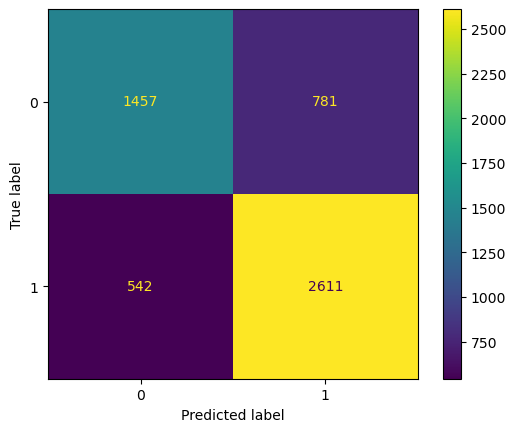

In [316]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_ts, y_val, model_xg3,'model_xg3')

| model name | hyperparameters                          | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler    | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |
| model_knn0 | default, no PCA, log, standard scaler    | 74.41%             | 61.57%                  | 0.64                              | 0.78                          | 18.29                  |
| model_rf0  | default, no PCA                          | 100.00%            | 73.77%                  | 0.72                              | 0.90                          | 22.35                  |
| model_gb0  | default, no PCA                          | 78.45%             | 75.64%                  | 0.76                              | 0.85                          | 154.61                 |
| model_xg0  | default, no PCA                          | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.78                  |
| model_xg1  | default, no PCA, log                     | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 45.16                  |
| model_xg2  | default, no PCA, log, standard scaler    | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.90                  |
| model_xg3  | default, no PCA,    , standard scaler    | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.61                  |

Finally, the performance of the XGBoost models was below the performance of logistic regression, which remains the best model so far in terms of overfitting, accuracy, and the precision and recall of the 'worth it' class. As expected of decision tree models, taking the LOG and scaling played no effect to the performance metrics of the XGBoost model. For hyperparameter tuning, both logistic regression and XGBoost will be tuned for thoroughness.

## Hyperparameter Optimization

### XGBoost Tuning

As the first round of hyperparameter optimization, 3 disttant values were chosen for each hyperparameter to keep the tuning time practical. After the initial rounds, the hyperparameter ranges will be fine tuned to find the best parameters.

In [224]:
# Define a dictionary containing parameters to testt
param_grid = {'n_estimators' : [100, 300, 500],#[1]+list(range(200,1001,200)), 
              'max_depth'    : [1, 3, 5], #[1]+list(range(5,21,5)), 
              'learning_rate': [0.1, 0.3, 0.5]#list(np.arange(0.1,1.1,0.2))
             }

In [225]:
# Define a GridSearch object where the estimator is just the XGBoost model
grid_xg0 = GridSearchCV(estimator = XGBClassifier(), 
                        param_grid = param_grid, 
                        verbose = 5, 
                        n_jobs = -1, 
                        refit = False,
                        cv = 5)

In [226]:
# Fit the GridSearch object to the remainder data
grid_xg0.fit(X_remainder_t, y_remainder);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.751 total time= 2.9min
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=100;, score=0.710 total time= 1.2min
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.756 total time= 5.6min
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=300;, score=0.768 total time= 8.6min
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500;, score=0.761 total time=13.8min
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=500;, score=0.766 total time=22.4min
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.753 total time= 2.8min
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.755 total time= 8.3min
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.762 total time= 4.5min
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.751 total time=13.5min
[CV 4/5] END learning_rate=0.3, max_depth=5, n_est

In [236]:
# Store the gridsearch results in a DataFrame
grid_xg0_results = pd.DataFrame(grid_xg0.cv_results_)

# Examine the top 5 ranking parameters
grid_xg0_results.sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,510.237058,5.899025,0.604057,0.011811,0.1,3,300,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.758301,0.767947,0.758813,0.761781,0.764193,0.762207,0.003573,1
5,831.188992,3.088350,0.658480,0.045530,0.1,3,500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.758672,0.767019,0.756957,0.763080,0.761224,0.761391,0.003510,2
7,809.420978,1.542064,0.642143,0.033197,0.1,5,300,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.755889,0.766463,0.754174,0.767161,0.762894,0.761316,0.005359,3
11,303.665655,1.915284,0.575806,0.009466,0.3,1,500,"{'learning_rate': 0.3, 'max_depth': 1, 'n_esti...",0.755147,0.763866,0.758627,0.766976,0.759184,0.760760,0.004167,4
20,301.601613,1.646768,0.593635,0.025869,0.5,1,500,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.756817,0.763680,0.757328,0.763636,0.757699,0.759832,0.003137,5


An initial grid search on 27 different parameter combinations and a 5 fold cross validation yielded a max mean_test_score of 76.22% accuracy. Although the accuracy is roughly the same as Logistic Regression, the time taken for fitting the model was significantly longer (510 seconds mean_fit_time for XGBoost vs Logistic Regression's 10s fit). Furthermore, the interpretability of Logistic Regression is better than XGBoost, which requires the Shapley package for model interpretation. As such, the next grid search will be performed using Logistic Regression.

In [324]:
# Fitting the basic model with the best model from GridSearchCV
model_xg4 = base_model_fit(X_train_t,
                           y_train, 
                           X_val_t, 
                           y_val, 
                           XGBClassifier(learning_rate = 0.1,
                                         max_depth = 3,
                                         n_estimators = 300))

Base fitting of a XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) with no hyperparameter adjustment.
Accuracy for train data: 83.38%
Accuracy for validation data: 77.28%
Time taken:73.1307 seconds


model_xg4: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      2238
           1       0.78      0.85      0.81      3153

    accuracy                           0.77      5391
   macro avg       0.77      0.76      0.76      5391
weighted avg       0.77      0.77      0.77      5391



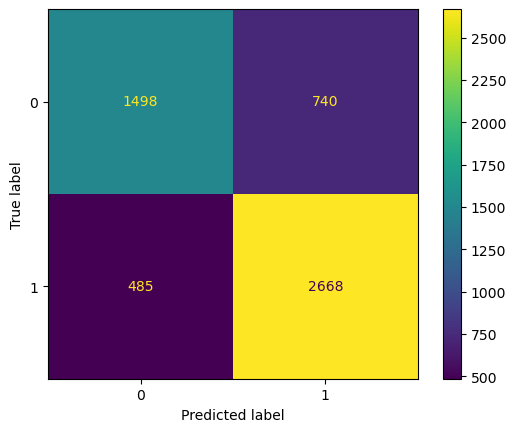

In [325]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_t, y_val, model_xg4,'model_xg4')

#### XGBoost Interpretation

In [401]:
# Initialize timer
start = time.perf_counter()

# Fit tree-specific kernel for SHAP  
explainer = shap.TreeExplainer(model_xg4)

# Obtain SHAP values 
shap_values = explainer.shap_values(X_val_t)

# End timer
end = time.perf_counter()

print(f"Time taken: {np.round(end-start,2)} seconds.")

Time taken: 0.61 seconds.


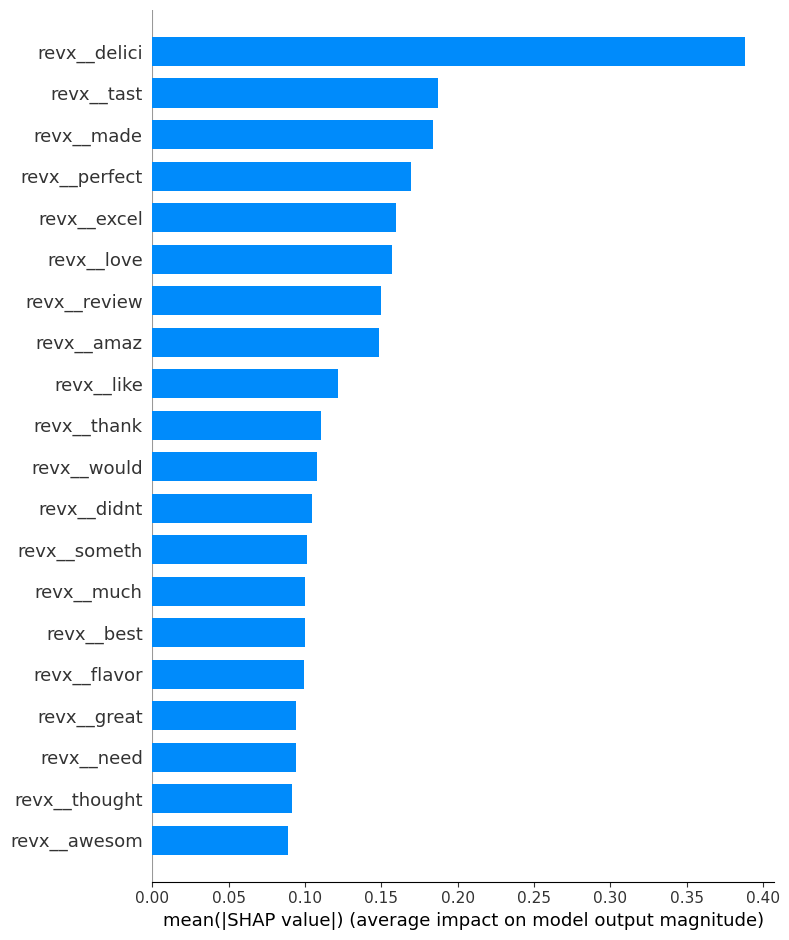

In [403]:
# Global interpretation - summary plot - type='bar'
shap.initjs()
shap.summary_plot(shap_values, features=X_val_t, feature_names=X_val_t.columns, plot_type='bar')

The Shapley Additive Explanations (SHAP) method was used to attempt model interpretation for XGBoost. A summary plot for global interpretation revealed that XGBoost ranked features generated from the 'review' column as most important. This may be a problem as not every recipe has reviews and the model is putting most of its weight onto the review column.

| model name | hyperparameters                                                                                                                        | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|----------------------------------------------------------------------------------------------------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it                                                                                               | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler                                                                                                  | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |
| model_knn0 | default, no PCA, log, standard scaler                                                                                                  | 74.41%             | 61.57%                  | 0.64                              | 0.78                          | 18.29                  |
| model_rf0  | default, no PCA                                                                                                                        | 100.00%            | 73.77%                  | 0.72                              | 0.90                          | 22.35                  |
| model_gb0  | default, no PCA                                                                                                                        | 78.45%             | 75.64%                  | 0.76                              | 0.85                          | 154.61                 |
| model_xg0  | default, no PCA                                                                                                                        | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.78                  |
| model_xg1  | default, no PCA, log                                                                                                                   | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 45.16                  |
| model_xg2  | default, no PCA, log, standard scaler                                                                                                  | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.90                  |
| model_xg3  | default, no PCA,    , standard scaler                                                                                                  | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.61                  |
| model_xg4  | no PCA, no log, no standard scaler<br>Best parameters from GridSearchCV:<br>learning_rate = 0.1<br>max_depth = 3<br>n_estimators = 300 | 83.38%             | 77.28%                  | 0.78                              | 0.85                          | 73.13                  |

Performing the same benchmark test using the best parameters from GridSearchCV for XGBoost yielded a reduction in overfitting and improved performance metrics that have overtaken the basic logsitic regression model. However, the time taken to train the XGBoost model was almost 8 times more than the basic logistic regression model.

### Logistic Regression Tuning

For tuning logistic regression, the log of the dependent features was taken to reduce the effect of outliers in the dataset and reduce distribution skewness. Furthermore, scalers such as standard scaler were employed to further transform the data into a more normally distributed form which contributes to the logistic regression solver's ability to converge onto a solution. 

#### Round 1: Larger Steps between Parameters

In [250]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
pipeline_lr = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('dim_reducer', PCA()), 
        ('model', LogisticRegression())
    ], 
    memory = cachedir
)

In [252]:
# Create parameter grid for logistic regression, total of 20 combinations
C_values = [10 ** c for c in range(-5,0)]

param_grid = [
    # Scenario 1 [20 combinations]: 4 scalers, 0 dim_reducer, penalty = L2, 5 c_values 
    {'scaler'     : [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model'      : [LogisticRegression(penalty      = 'l2',
                                        solver       = 'lbfgs',
                                        random_state = rs, 
                                        n_jobs       = -1,
                                        max_iter     = 10000)],
     'model__C'   : C_values}
]

In [254]:
# Define a GridSearch object where the estimator is pipeline_lr
grid_lr0 = GridSearchCV(estimator = pipeline_lr, 
                         param_grid = param_grid, 
                         cv = 5, # 5 fold cross validation
                         n_jobs = -1, # use all processors
                         verbose = 3, # display message
                         refit = False # avoid getting stuck
                         )

In [255]:
# Perform log transformation to deal with outliers and skewed distributions
X_remainder_tl = np.log(X_remainder_t +1)

# Fit the GridSearch object to the remainder data
grid_lr0.fit(X_remainder_tl, y_remainder)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/hc/dd4qvphd7j59ktfp1751r_4h0000gn/T/tmpncf_vnhg',
                                steps=[('scaler', StandardScaler()),
                                       ('dim_reducer', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'dim_reducer': [None],
                          'model': [LogisticRegression(max_iter=10000,
                                                       n_jobs=-1,
                                                       random_state=42)],
                          'model__C': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                          'scaler': [None, StandardScaler(), MinMaxScaler(),
                                     RobustScaler()]}],
             refit=False, verbose=3)

[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=None;, score=0.585 total time=   5.1s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=StandardScaler();, score=0.613 total time=   7.2s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=RobustScaler();, score=0.605 total time=  10.7s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=MinMaxScaler();, score=0.585 total time=   4.1s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=RobustScaler();, score=0.729 total time=  15.9s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=StandardScaler();, sco

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params

[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=None;, score=0.585 total time=   5.2s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=StandardScaler();, score=0.610 total time=   7.2s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=None;, score=0.585 total time=   3.8s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=None;, score=0.585 total time=   3.8s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=StandardScaler();, score=0.744 total time=   6.9s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=RobustScaler();, score=0.730 total tim

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=None;, score=0.585 total time=   5.1s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=MinMaxScaler();, score=0.585 total time=   6.9s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=RobustScaler();, score=0.608 total time=  11.1s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=MinMaxScaler();, score=0.585 total time=   5.8s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=RobustScaler();, score=0.733 total time=  15.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=MinMaxScaler();, score=0

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params

[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=StandardScaler();, score=0.612 total time=   8.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=RobustScaler();, score=0.600 total time=   7.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=None;, score=0.585 total time=   3.8s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=StandardScaler();, score=0.753 total time=   6.6s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=MinMaxScaler();, score=0.585 total time=   5.7s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=None;, score=0.611 

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=StandardScaler();, score=0.609 total time=   8.0s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=MinMaxScaler();, score=0.585 total time=   5.2s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=None;, score=0.585 total time=   5.4s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=StandardScaler();, score=0.757 total time=   8.9s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=RobustScaler();, score=0.740 total time=  15.4s
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=None;, score=0.609 

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 1.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=None;, score=0.585 total time=   5.0s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=MinMaxScaler();, score=0.585 total time=   6.9s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=RobustScaler();, score=0.604 total time=  11.1s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=MinMaxScaler();, score=0.585 total time=   5.8s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=None;, score=0.611 total time=  12.8s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=None;, score=0.604 total time=   7.

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params

[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=None;, score=0.585 total time=   5.1s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=MinMaxScaler();, score=0.585 total time=   4.8s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=RobustScaler();, score=0.600 total time=   8.3s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=StandardScaler();, score=0.739 total time=   9.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=RobustScaler();, score=0.735 total time=  15.6s
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=StandardScaler();, sco

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 1.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params

[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=StandardScaler();, score=0.611 total time=   8.0s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=1e-05, scaler=MinMaxScaler();, score=0.585 total time=   5.3s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=None;, score=0.584 total time=   5.3s
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=StandardScaler();, score=0.743 total time=   6.6s
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.0001, scaler=MinMaxScaler();, score=0.585 total time=   6.1s
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.001, scaler=None;, score=0.600 

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 0.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


In [258]:
# Store the gridsearch results in a DataFrame
grid_lr0_results = pd.DataFrame(grid_lr0.cv_results_)

# Examine the top 5 ranking parameters
grid_lr0_results.sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reducer,param_model,param_model__C,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,62.921441,7.514810,0.387745,0.080116,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.01,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.764608,0.768503,0.759555,0.765121,0.764378,0.764433,0.002859,1
19,82.079095,2.412198,0.211195,0.093766,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.1,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.763124,0.769616,0.759926,0.766234,0.758998,0.763579,0.003950,2
9,9.020197,0.301271,0.546269,0.105469,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.001,StandardScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.756446,0.766277,0.756957,0.762152,0.755659,0.759498,0.004087,3
11,30.669367,1.757950,0.357569,0.053393,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.001,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.757188,0.766092,0.754545,0.759369,0.760111,0.759461,0.003840,4
13,18.330360,1.039090,0.313261,0.031092,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.01,StandardScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.754591,0.766092,0.756215,0.761410,0.750649,0.757791,0.005399,5


The initial round of hyperparameter optimization yielded the best parameters of a normalization factor around 0.01 and 0.1 with RobustScaler() as the best scaler. This was expected as RobustScaler is better at dealing with outliers which are present within the data as it depends on the median and the interquatile range of the data. The next round of tuning will be focused on fine tuning the C-value.

#### Round 2: Fixed RobustScaler, Finetuning Normalization Factors

In [274]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
pipeline_lr = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('dim_reducer', PCA()), 
        ('model', LogisticRegression())
    ], 
    memory = cachedir
)

In [283]:
# Create parameter grid for logistic regression, total of 40 combinations
C_values = np.arange(0.005,0.201,0.005)

param_grid = [
    # Scenario 1 [40 combinations]: 1 scalers, 0 dim_reducer, penalty = L2, 40 c_values 
    {'scaler'     : [RobustScaler()],
     'dim_reducer': [None],
     'model'      : [LogisticRegression(penalty      = 'l2',
                                        solver       = 'lbfgs',
                                        random_state = rs, 
                                        n_jobs       = -1,
                                        max_iter     = 10000)],
     'model__C'   : C_values}
]

In [285]:
# Define a GridSearch object where the estimator is pipeline_lr
grid_lr1 = GridSearchCV(estimator = pipeline_lr, 
                         param_grid = param_grid, 
                         cv = 5, # 5 fold cross validation
                         n_jobs = -1, # use all processors
                         verbose = 3, # display message
                         refit = False # avoid getting stuck
                         )

In [286]:
# Perform log transformation to deal with outliers and skewed distributions
X_remainder_tl = np.log(X_remainder_t +1)

# Fit the GridSearch object to the remainder data
grid_lr1.fit(X_remainder_tl, y_remainder)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/hc/dd4qvphd7j59ktfp1751r_4h0000gn/T/tmpncf_vnhg',
                                steps=[('scaler', StandardScaler()),
                                       ('dim_reducer', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'dim_reducer': [None],
                          'model': [LogisticRegression(max_iter=10000,
                                                       n_jobs=-1,
                                                       random_state=42)],
                          'model__C': array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  ]),
                          'scaler

[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.005, scaler=RobustScaler();, score=0.763 total time= 1.1min
[CV 5/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.015, scaler=RobustScaler();, score=0.763 total time= 1.3min
[CV 4/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.025, scaler=RobustScaler();, score=0.766 total time= 1.2min
[CV 1/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.034999999999999996, scaler=RobustScaler();, score=0.763 total time= 1.2min
[CV 3/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.04, scaler=RobustScaler();, score=0.761 total time= 1.7min
[CV 2/5] END dim_reducer=None, model=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42), model__C=0.04999999999999

In [287]:
# Store the gridsearch results in a DataFrame
grid_lr1_results = pd.DataFrame(grid_lr1.cv_results_)

# Examine the top 5 ranking parameters
grid_lr1_results.sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reducer,param_model,param_model__C,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,79.414806,7.341504,0.398955,0.051434,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.03,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.764051,0.769616,0.761781,0.766419,0.761410,0.764656,0.003062,1
2,67.324063,6.426331,0.439472,0.044112,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.015,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.763866,0.768689,0.761039,0.766234,0.762894,0.764544,0.002665,2
9,99.816594,10.355565,0.366173,0.056471,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.05,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.764422,0.771656,0.761781,0.765677,0.759184,0.764544,0.004201,3
1,61.558260,3.969256,0.463462,0.158499,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.01,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.764608,0.768503,0.759555,0.765121,0.764378,0.764433,0.002859,4
4,74.189950,6.538703,0.404294,0.066937,None,"LogisticRegression(max_iter=10000, n_jobs=-1, ...",0.025,RobustScaler(),"{'dim_reducer': None, 'model': LogisticRegress...",0.764422,0.769616,0.760853,0.766234,0.761039,0.764433,0.003300,5


From the second GridSearchCV, the best normalization factor was a C-value of 0.03 and a mean_test_score of 76.14%. Finally, applying the same benchmark test using the optimized parameters.

In [326]:
# Apply log to deal with outliers and skew of data
X_train_tl = np.log(X_train_t+1)

# Apply standard scaler to ease convergence of logistic regression function
scaler_robust = RobustScaler()
X_train_tlr = scaler_robust.fit_transform(X_train_tl)

# Apply the same transformation to 
X_val_tl = np.log(X_val_t+1)
X_val_tlr = scaler_robust.transform(X_val_tl)

In [327]:
# Fitting the basic model with the best model from GridSearchCV
model_lr1 = base_model_fit(X_train_tlr,
                           y_train, 
                           X_val_tlr, 
                           y_val, 
                           LogisticRegression(C = 0.03,
                                              penalty      = 'l2',
                                              solver       = 'lbfgs',
                                              random_state = rs, 
                                              n_jobs       = -1,
                                              max_iter     = 10000))

Base fitting of a LogisticRegression(C=0.03, max_iter=10000, n_jobs=-1, random_state=42) with no hyperparameter adjustment.
Accuracy for train data: 77.68%
Accuracy for validation data: 76.52%
Time taken:200.0603 seconds


model_lr1: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      2238
           1       0.78      0.83      0.81      3153

    accuracy                           0.77      5391
   macro avg       0.76      0.75      0.75      5391
weighted avg       0.76      0.77      0.76      5391



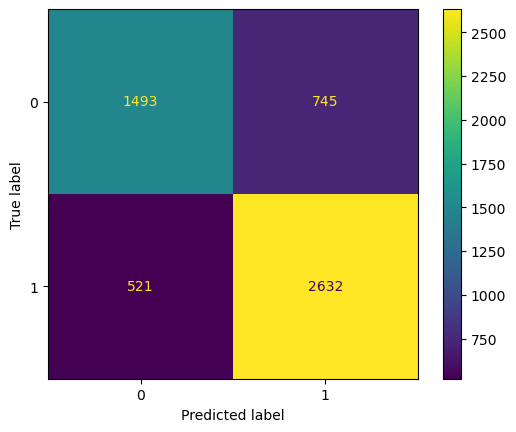

In [328]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_val_tlr, y_val, model_lr1,'model_lr1')

##### Optimized Logistic Regression Model Coefficient Analysis

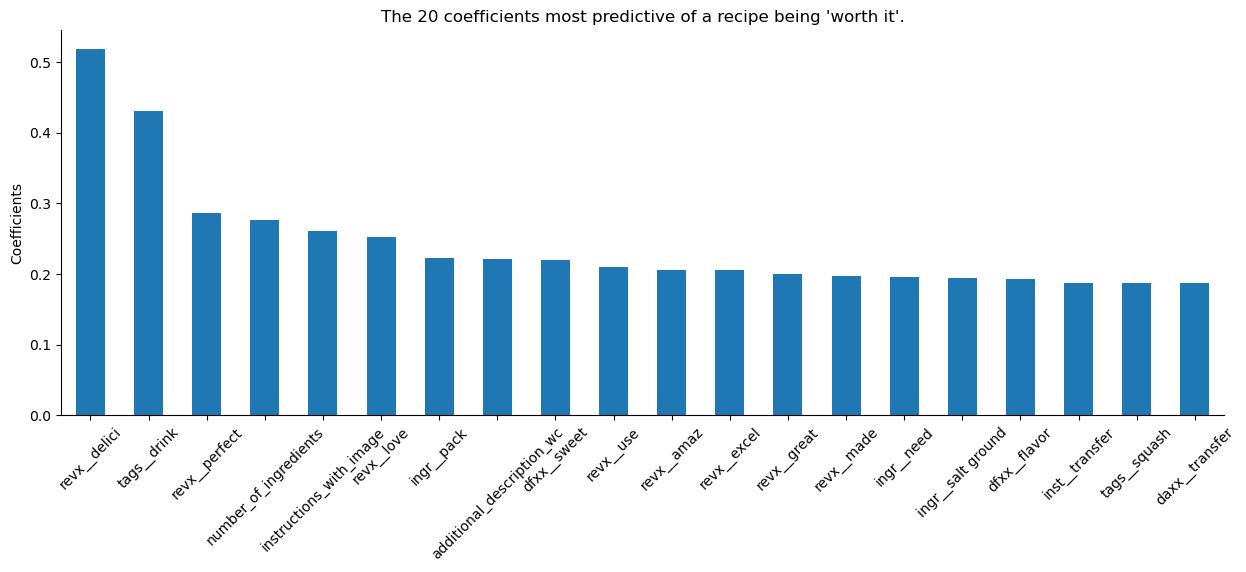

,coefficients,odds_ratio
revx__delici,0.518990,1.680330
tags__drink,0.430837,1.538545
revx__perfect,0.285653,1.330631
number_of_ingredients,0.276374,1.318341
instructions_with_image,0.260188,1.297174
revx__love,0.252451,1.287176
ingr__pack,0.222220,1.248846
additional_description_wc,0.221462,1.247900
dfxx__sweet,0.219186,1.245063
revx__use,0.210390,1.234160


In [332]:
 # The coefficients were loaded into a DataFrame, with the labels being the column names of training data
model_lr1_coef = pd.DataFrame(
    {"coefficients": model_lr1.coef_[0]},
    index=X_val_t.columns
)

# Show top 20 positive coeffiecients
pos_coef = model_lr1_coef.sort_values(by = 'coefficients', ascending = False).head(20)

pos_coef.plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 coefficients most predictive of a recipe being 'worth it'.")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Calculate odds ratio
pos_coef['odds_ratio'] = np.exp(pos_coef['coefficients'])
display(pos_coef.head(20))

Examining the coefficients of the fitted model_lr1, the `number_of_ingredients` and including images as part of instructions were observed to increase the odds of a recipe being worth it by approximately 30%. This can be explained by recipes being easier to follow if the instructions had images for each step. A recipe is also more likely to be more flavour if more ingredients are in the recipe. In terms of text columns, the ngram 'delicious' within the review text increases the odds by 68%. Interestingly, the tag of 'drink' increases the odds of a recipe being worth it by 54%. Further studies may be carried out to determine if and why recipes tagged with 'drink' tend to be more worth it. 

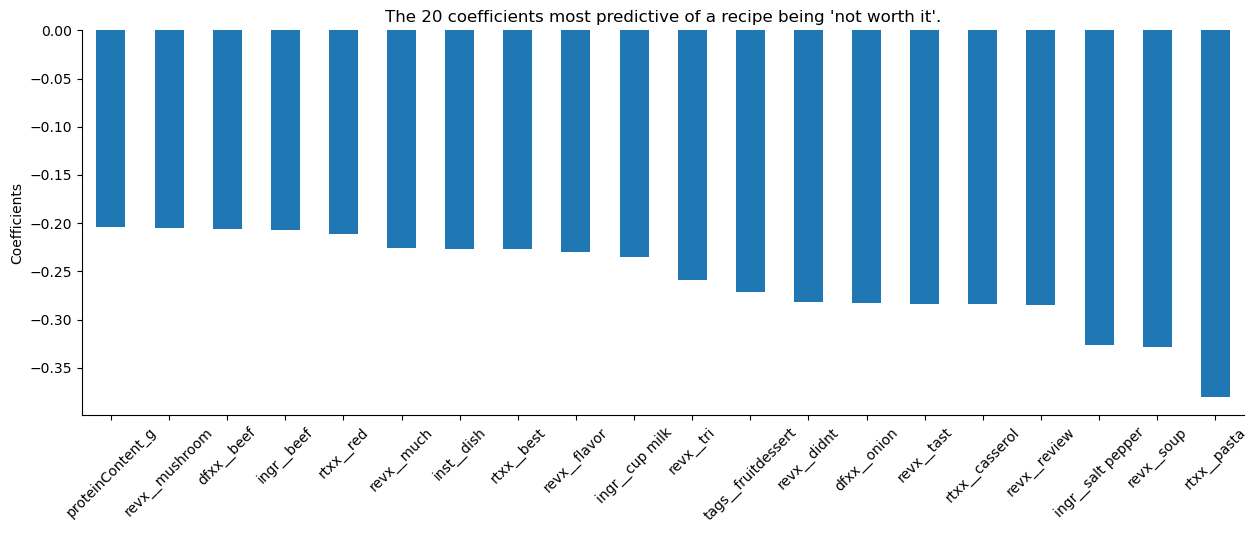

,coefficients,odds_ratio
proteinContent_g,-0.204299,0.815219
revx__mushroom,-0.205040,0.814614
dfxx__beef,-0.205971,0.813857
ingr__beef,-0.207148,0.812900
rtxx__red,-0.211235,0.809584
revx__much,-0.225562,0.798067
inst__dish,-0.227117,0.796828
rtxx__best,-0.227169,0.796786
revx__flavor,-0.230451,0.794176
ingr__cup milk,-0.234886,0.790661


In [333]:
 # The coefficients were loaded into a DataFrame, with the labels being the column names of training data
model_lr1_coef = pd.DataFrame(
    {"coefficients": model_lr1.coef_[0]},
    index=X_val_t.columns
)

# Show top 20 negative coeffiecients
neg_coef = model_lr1_coef.sort_values(by = 'coefficients', ascending = False).tail(20)

neg_coef.plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 coefficients most predictive of a recipe being 'not worth it'.")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Calculate odds ratio
neg_coef['odds_ratio'] = np.exp(neg_coef['coefficients'])
display(neg_coef.tail(20))

In reverse, interestingly having a low protein content in a recipe decreases the odds of a recipe being worth it by approximately 18% (1-0.82). Interestingly, the presense of beef in the description flavour text and the ingredients also reduces the odds by roughly 18%. Initial intuition was the observed negative effect of beef may be due to religious reasons such as Hinduism, but the lack of pork in the botttom 20 contradicts this intuition and suggests further studies. 

For recipe titles, having the word 'casserole' and 'pasta' descreases the odds of a recipe being wortth it by 25% and 32% respectively. Further studies may be performed to further analyze the vectorized ngrams o better understand these observations.

| model name | hyperparameters                                                                                                                        | train <br>accuracy | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class | run-time <br>(seconds) |
|------------|----------------------------------------------------------------------------------------------------------------------------------------|--------------------|-------------------------|-----------------------------------|-------------------------------|------------------------|
| baseline   | blindly guessing all recipes as worth it                                                                                               | 58.48%             | 58.48%                  | -                                 | -                             | -                      |
| model_lr0  | default, no PCA, log, standard scaler                                                                                                  | 78.58%             | 76.03%                  | 0.78                              | 0.82                          | 9.71                   |
| model_knn0 | default, no PCA, log, standard scaler                                                                                                  | 74.41%             | 61.57%                  | 0.64                              | 0.78                          | 18.29                  |
| model_rf0  | default, no PCA                                                                                                                        | 100.00%            | 73.77%                  | 0.72                              | 0.90                          | 22.35                  |
| model_gb0  | default, no PCA                                                                                                                        | 78.45%             | 75.64%                  | 0.76                              | 0.85                          | 154.61                 |
| model_xg0  | default, no PCA                                                                                                                        | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.78                  |
| model_xg1  | default, no PCA, log                                                                                                                   | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 45.16                  |
| model_xg2  | default, no PCA, log, standard scaler                                                                                                  | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.90                  |
| model_xg3  | default, no PCA,    , standard scaler                                                                                                  | 97.95%             | 75.46%                  | 0.77                              | 0.83                          | 44.61                  |
| model_xg4  | no PCA, no log, no standard scaler<br>Best parameters from GridSearchCV:<br>learning_rate = 0.1<br>max_depth = 3<br>n_estimators = 300 | 83.38%             | 77.28%                  | 0.78                              | 0.85                          | 73.13                  |
| model_lr1  | no PCA, log, robust scaler, C = 0.03                                                                                                   | 77.68%             | 76.52%                  | 0.78                              | 0.83                          | 200.06                 |

Ultimately, after two rounds of hyperparameter optimization, the optimized logistic regression model performed better than the base model but did not outperform an optimized XGBoost model. In terms of time, the optimized XGBoost modedl took less than half the time of the optimized logistic regression model. 

Refering to the confusion matrices of both models, in terms of precision and recall, model_xg4 had 485 false negatives and 740 false positives, which is better than model_lr1's performance of 521 false negatives and 745 false positives.

However, although XGBoost outperformed logistic regression in terms of metrics, a deeper dive into feature importance by model revealed that XGBoost ranks only the features from the 'review' column with high importance while logistic regression was observed to rank a combination of features as its top coefficients.

Since not every recipe will have written reviews, the logistic regression model was ultimately chosen to be the final model. The increase in interpretability and a better mix of top coefficients was ultimately deemed more important that the performance metrics, given that the xgboost model only outperforms logistic regression by 1%.

# Final Model

Before final testing and reporting, the parameters from model_lr1 were extracted and used to fit and train a logistic regression model on the remainder dataset(train + validation).

In [404]:
# Initiate timer
start = time.perf_counter()

# Apply log to remove outliers
X_remainder_tl = np.log(X_remainder_t+1)

# Initiate Robust Scaler, then fit and transform X_remainder_tl
final_robust_scaler = RobustScaler()
X_remainder_tlr = final_robust_scaler.fit_transform(X_remainder_tl)

# Initiate the final model
final_model = LogisticRegression(C = 0.03,
                              penalty      = 'l2',
                              solver       = 'lbfgs',
                              random_state = rs, 
                              n_jobs       = -1,
                              max_iter     = 10000)

# Fit the final model
final_model.fit(X_remainder_tlr, y_remainder)

# End timer
end = time.perf_counter()
print(f"Time taken: {np.round(end-start,2)} seconds.")
print(f"Accuracy for remainder data: {np.round(final_model.score(X_remainder_tlr,y_remainder)*100,2)}%")

Time taken: 325.95 seconds.
Accuracy for remainder data: 77.72%


Applying the same transformations used on the remainder data to the test data.

In [405]:
# Apply OHE and TF-IDF vectorizer using Column Transformer to the test data
# Initiate timer
start = time.perf_counter()

print(f"Shape at start: {X_test.shape}")

# Apply KNN imputer
num_df = X_test.select_dtypes(include = 'number')
tex_df = X_test.select_dtypes(exclude = 'number')
num_df_tf =  pd.DataFrame(imputer.transform(num_df),
                          columns = num_df.columns.to_list())
X_test_t = pd.concat([num_df_tf, tex_df], axis = 1)

print(f"Shape after KNN imputer: {X_test_t.shape}")

# Apply the ColumnTransformer
transformed = col_transformer.transform(X_test_t) 
transformed_df = pd.DataFrame(transformed.todense(), 
                              columns=col_transformer.get_feature_names_out())
X_test_t = pd.concat([X_test_t, transformed_df], axis = 1)

print(f"Shape after ColumnTransformer: {X_test_t.shape}")

# Dropping vectorized columns
X_test_t = X_test_t.select_dtypes('number').copy()
X_test_t.drop(columns = ['published_quarter'], inplace = True)
print(f"Shape after dropping vectorized columns: {X_test_t.shape}")

print(f"Checking for null values: {X_test_t.isna().sum().sum()}.")
print(f"Checking shape of numerical columns:{X_test_t.select_dtypes('number').shape}")


end = time.perf_counter()
print(f"Time taken for column transformations: {np.round(end-start,3)} seconds.")

Shape at start: (6739, 29)
Shape after KNN imputer: (6739, 29)
Shape after ColumnTransformer: (6739, 1038)
Shape after dropping vectorized columns: (6739, 1029)
Checking for null values: 0.
Checking shape of numerical columns:(6739, 1029)
Time taken for column transformations: 189.365 seconds.


Final testing on the transformed test data:

In [406]:
X_test_tl = np.log(X_test_t+1)
X_test_tlr = final_robust_scaler.transform(X_test_tl)
print(f"Accuracy for test data: {np.round(final_model.score(X_test_tlr,y_test)*100,2)}%")

Accuracy for test data: 76.36%


final model: Classification report for a threshold of 0.5 + confusion matrix

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      2798
           1       0.78      0.83      0.80      3941

    accuracy                           0.76      6739
   macro avg       0.76      0.75      0.75      6739
weighted avg       0.76      0.76      0.76      6739



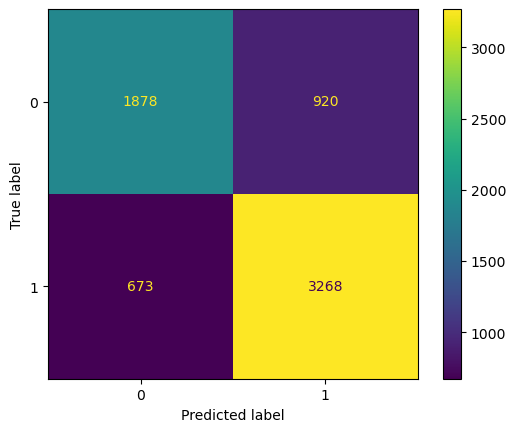

In [407]:
# Generate confusion matrix using predefined function
generate_confusion_matrix(X_test_tlr, y_test, final_model,'final model')

After testing the final model on the unseen test data, the remainder accuracy was 77.72% while the test accuracy was 76.36%. On the test data, the final model had a precision of 0.78 and a recall of 0.83, with 673 false negatives and 920 false positives. Overall, this was a better performance than the base logistic regression model. Again, the final metrics and the runtime of 325.95 seconds is inferior to the results by model_xg4. However, unlike model_xg4, the logistic regression model offers similar performance by using a better mixture of features for the top coefficients, thus making it the model of choice.

## Analysis of Final Model

The final model was further analyzed in terms of predicted probability and model coefficients. To analyze predicted probability, the predicted probabilities must be generated and attached to the data for comparison.

In [408]:
# Extracting the prediction results
y_pred = final_model.predict(X_test_tlr)

# Extracting the prediction probabilities
y_prob = final_model.predict_proba(X_test_tlr)

In [410]:
# Rejoining the target feature back to the dependent variables for analysis
model_analysis_df = pd.concat(
    [pd.DataFrame(X_test_tlr,columns = X_test_t.columns), 
     y_test.reset_index(drop=True)],
    axis = 1)

In [411]:
# Adding predictions and probabilities to understand where mistakes happened
model_analysis_df['y_pred'] = y_pred
model_analysis_df['prob_0'] = y_prob[:,0]
model_analysis_df['prob_1'] = y_prob[:,1]

In [413]:
print(f"Shape of analysis DataFrame: {model_analysis_df.shape}")
model_analysis_df.head()

Shape of analysis DataFrame: (6739, 1033)


,recipe_title_wc,number_of_ratings,description_wc,additional_description_wc,description_flavour_text_wc,instructions_with_image,number_of_ingredients,calories_kcal,carbohydrateContent_g,cholesterolContent_mg,...,revx__wonder,revx__work,revx__would,revx__written,revx__year,revx__yummi,recipe_worth_it,y_pred,prob_0,prob_1
0,-0.550340,-0.151130,-0.093426,-1.731421,-1.351079,0.0,-1.119715,-0.067248,-1.288211,0.068090,...,-0.395187,1.756780,2.610611,0.00000,1.649171,2.327982,0,0,0.642179,0.357821
1,-0.550340,-0.883392,-0.786851,-0.648510,0.743553,0.0,-0.360468,-1.375128,-0.312666,-1.905183,...,-0.395187,-0.416598,-0.842408,0.00000,0.000000,-0.358239,0,0,0.938784,0.061216
2,-1.259851,-0.789978,-1.430832,-1.123905,0.000000,0.0,-1.944906,-0.234238,-0.956771,0.376310,...,-0.395187,-0.416598,0.958030,0.00000,0.000000,3.569110,1,0,0.685464,0.314536
3,0.000000,-0.423483,0.351365,-0.552348,-0.958606,0.0,-0.576175,-0.684774,-0.520022,-1.150272,...,-0.395187,-0.416598,-0.842408,0.00000,0.000000,-0.358239,1,1,0.376253,0.623747
4,-0.550340,-0.054091,-0.967254,-0.668615,-2.042969,0.0,0.294523,-1.297983,-0.787350,-1.428887,...,1.057625,0.455525,0.124899,1.69383,0.000000,1.764187,0,0,0.837739,0.162261


Referring to the last few columns (scroll right), the model predictions and prediction probabilities were attached.

In [414]:
# Create a loop to identify which rows are true positive, true negative and etc
recipe_labels = list()
for index, recipe in model_analysis_df[['recipe_worth_it','y_pred']].iterrows():
    if recipe['recipe_worth_it'] == 1 and recipe['y_pred'] == 1:
        recipe_labels.append('True Positive')
    elif recipe['recipe_worth_it'] == 0 and recipe['y_pred'] == 0:
        recipe_labels.append('True Negative')
    elif recipe['recipe_worth_it'] == 0 and recipe['y_pred'] == 1:
        recipe_labels.append('False Positive')
    elif recipe['recipe_worth_it'] == 1 and recipe['y_pred'] == 0:
        recipe_labels.append('False Negative')
    else:
        recipe_labels.append('Check')

In [415]:
# Attach identity back to analysis dataframe
model_analysis_df['identifier'] = recipe_labels

In [416]:
# Perform value counts to check against confusion matrix
model_analysis_df['identifier'].value_counts()

True Positive     3268
True Negative     1878
False Positive     920
False Negative     673
Name: identifier, dtype: int64

The values match up with the confusion matrix generated for the final model.

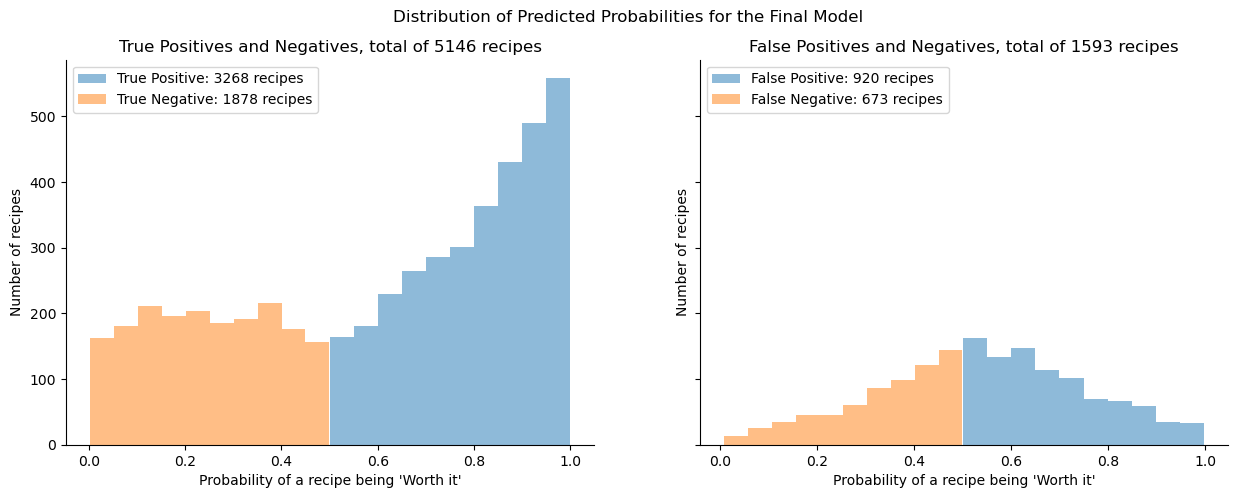

In [417]:
# Define conditions to filter DataFrames
cond1 = model_analysis_df['identifier'] == 'True Positive'
cond2 = model_analysis_df['identifier'] == 'True Negative'

cond3 = model_analysis_df['identifier'] == 'False Positive'
cond4 = model_analysis_df['identifier'] == 'False Negative'

# Initiate subplot object
plt.subplots(1,2, figsize = (15,5), sharey = True)


plt.subplot(1,2,1)
plt.hist(x = model_analysis_df[cond1]['prob_1'], 
         label = f"True Positive: {cond1.sum()} recipes", 
         alpha = 0.5, 
         bins = 10)
plt.hist(x = model_analysis_df[cond2]['prob_1'], 
         label = f"True Negative: {cond2.sum()} recipes", 
         alpha = 0.5, 
         bins = 10)
plt.legend(loc = 'upper left')
plt.ylabel('Number of recipes')
plt.xlabel("Probability of a recipe being 'Worth it'")
plt.title(f"True Positives and Negatives, total of {cond1.sum()+cond2.sum()} recipes")
sns. despine()

plt.subplot(1,2,2)
plt.hist(x = model_analysis_df[cond3]['prob_1'], 
         label = f"False Positive: {cond3.sum()} recipes", 
         alpha = 0.5, 
         bins = 10)
plt.hist(x = model_analysis_df[cond4]['prob_1'], 
         label = f"False Negative: {cond4.sum()} recipes", 
         alpha = 0.5, 
         bins = 10)
plt.legend(loc = 'upper left')
plt.ylabel('Number of recipes')
plt.xlabel("Probability of a recipe being 'Worth it'")
plt.title(f"False Positives and Negatives, total of {cond3.sum()+cond4.sum()} recipes")
sns. despine()

plt.suptitle(f"Distribution of Predicted Probabilities for the Final Model")

plt.savefig('images/final_model_predict_proba.png', dpi = 300)

plt.show()

Based on the default decision boundary of 0.5, with greater than or equal to 0.5 being 'worth it', mapping the predicted distributions revealed that the model is relatively confident about its decision making. Referring to the above figure, on the left subplot, it was observed that most true positives were predicted with a confident probablity of 0.8 - 1.0. For true negatives, the model appears to be less confident about its decision making as it has a relatively flat distribution from 0 to 0.5. 

The subplot on the right revealed that most of the mistakes were due to the model predicting probabilities between 0.4 and 0.6. The peak between 0.4 and 0.6 suggests the model is not predicting very strong probabilities for its mistakes, which suggests that the model is robust.

### Coefficient Analysis

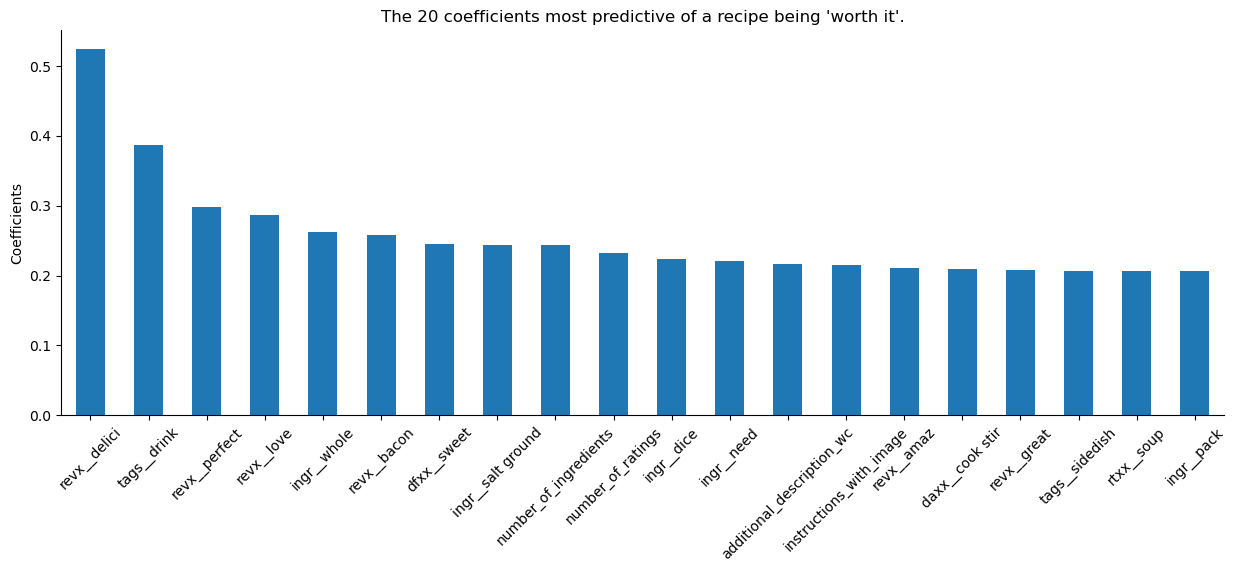

,coefficients,odds_ratio
revx__delici,0.525041,1.690528
tags__drink,0.387489,1.473276
revx__perfect,0.298776,1.348208
revx__love,0.286780,1.332131
ingr__whole,0.261839,1.299317
revx__bacon,0.258003,1.294342
dfxx__sweet,0.244660,1.277187
ingr__salt ground,0.244158,1.276546
number_of_ingredients,0.243495,1.275700
number_of_ratings,0.232087,1.261229


In [418]:
 # The coefficients were loaded into a DataFrame, with the labels being the column names of training data
final_model_coef = pd.DataFrame(
    {"coefficients": final_model.coef_[0]},
    index=X_test_t.columns
)

# Show top 20 positive coeffiecients
pos_coef = final_model_coef.sort_values(by = 'coefficients', ascending = False).head(20)

pos_coef.plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 coefficients most predictive of a recipe being 'worth it'.")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Calculate odds ratio
pos_coef['odds_ratio'] = np.exp(pos_coef['coefficients'])
display(pos_coef.head(20))

Aside from ngrams from the `review` column, a good combination of other vectorized features such as ingredients and description were included. Furthermore, numerical columns that were not vectorized such `number_of_ingredients` and `number_of_ratings` also appear in the top 20 coefficients. Similar to model_lr1, the top 5 coefficients show that the recipe being tagged as a drink and the recipe using whole ingredients were more likely to be 'worth it' recipes.

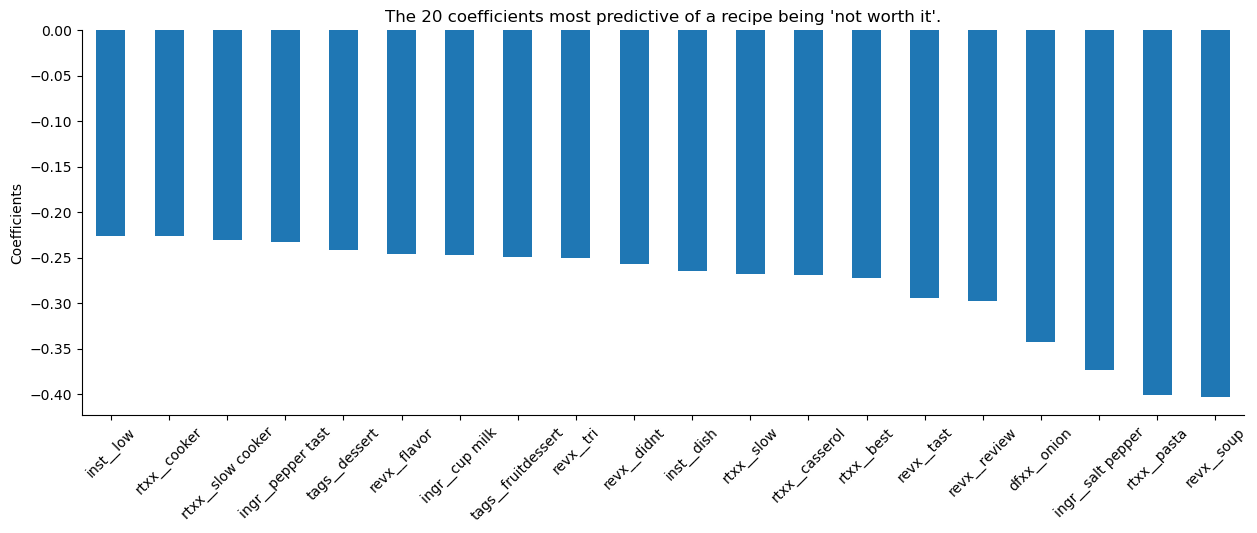

,coefficients,odds_ratio
inst__low,-0.225622,0.798019
rtxx__cooker,-0.225742,0.797924
rtxx__slow cooker,-0.230286,0.794306
ingr__pepper tast,-0.232462,0.792580
tags__dessert,-0.240951,0.785880
revx__flavor,-0.245773,0.782100
ingr__cup milk,-0.246929,0.781196
tags__fruitdessert,-0.248923,0.779640
revx__tri,-0.249972,0.778823
revx__didnt,-0.256828,0.773501


In [419]:
 # The coefficients were loaded into a DataFrame, with the labels being the column names of training data
final_model_coef = pd.DataFrame(
    {"coefficients": final_model.coef_[0]},
    index=X_test_t.columns
)

# Show top 20 negative coeffiecients
neg_coef = final_model_coef.sort_values(by = 'coefficients', ascending = False).tail(20)

neg_coef.plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 coefficients most predictive of a recipe being 'not worth it'.")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Calculate odds ratio
neg_coef['odds_ratio'] = np.exp(neg_coef['coefficients'])
display(neg_coef.tail(20))

Similar to model_lr1, the final model also penalized heavily if the recipe has pasta in the title and salt pepper as an ingredient. This might be due to a large amounts of pasta recipes in allrecipes.com along with salt pepper being so common that it doesn't add any value to making a recipe 'worth it'. 

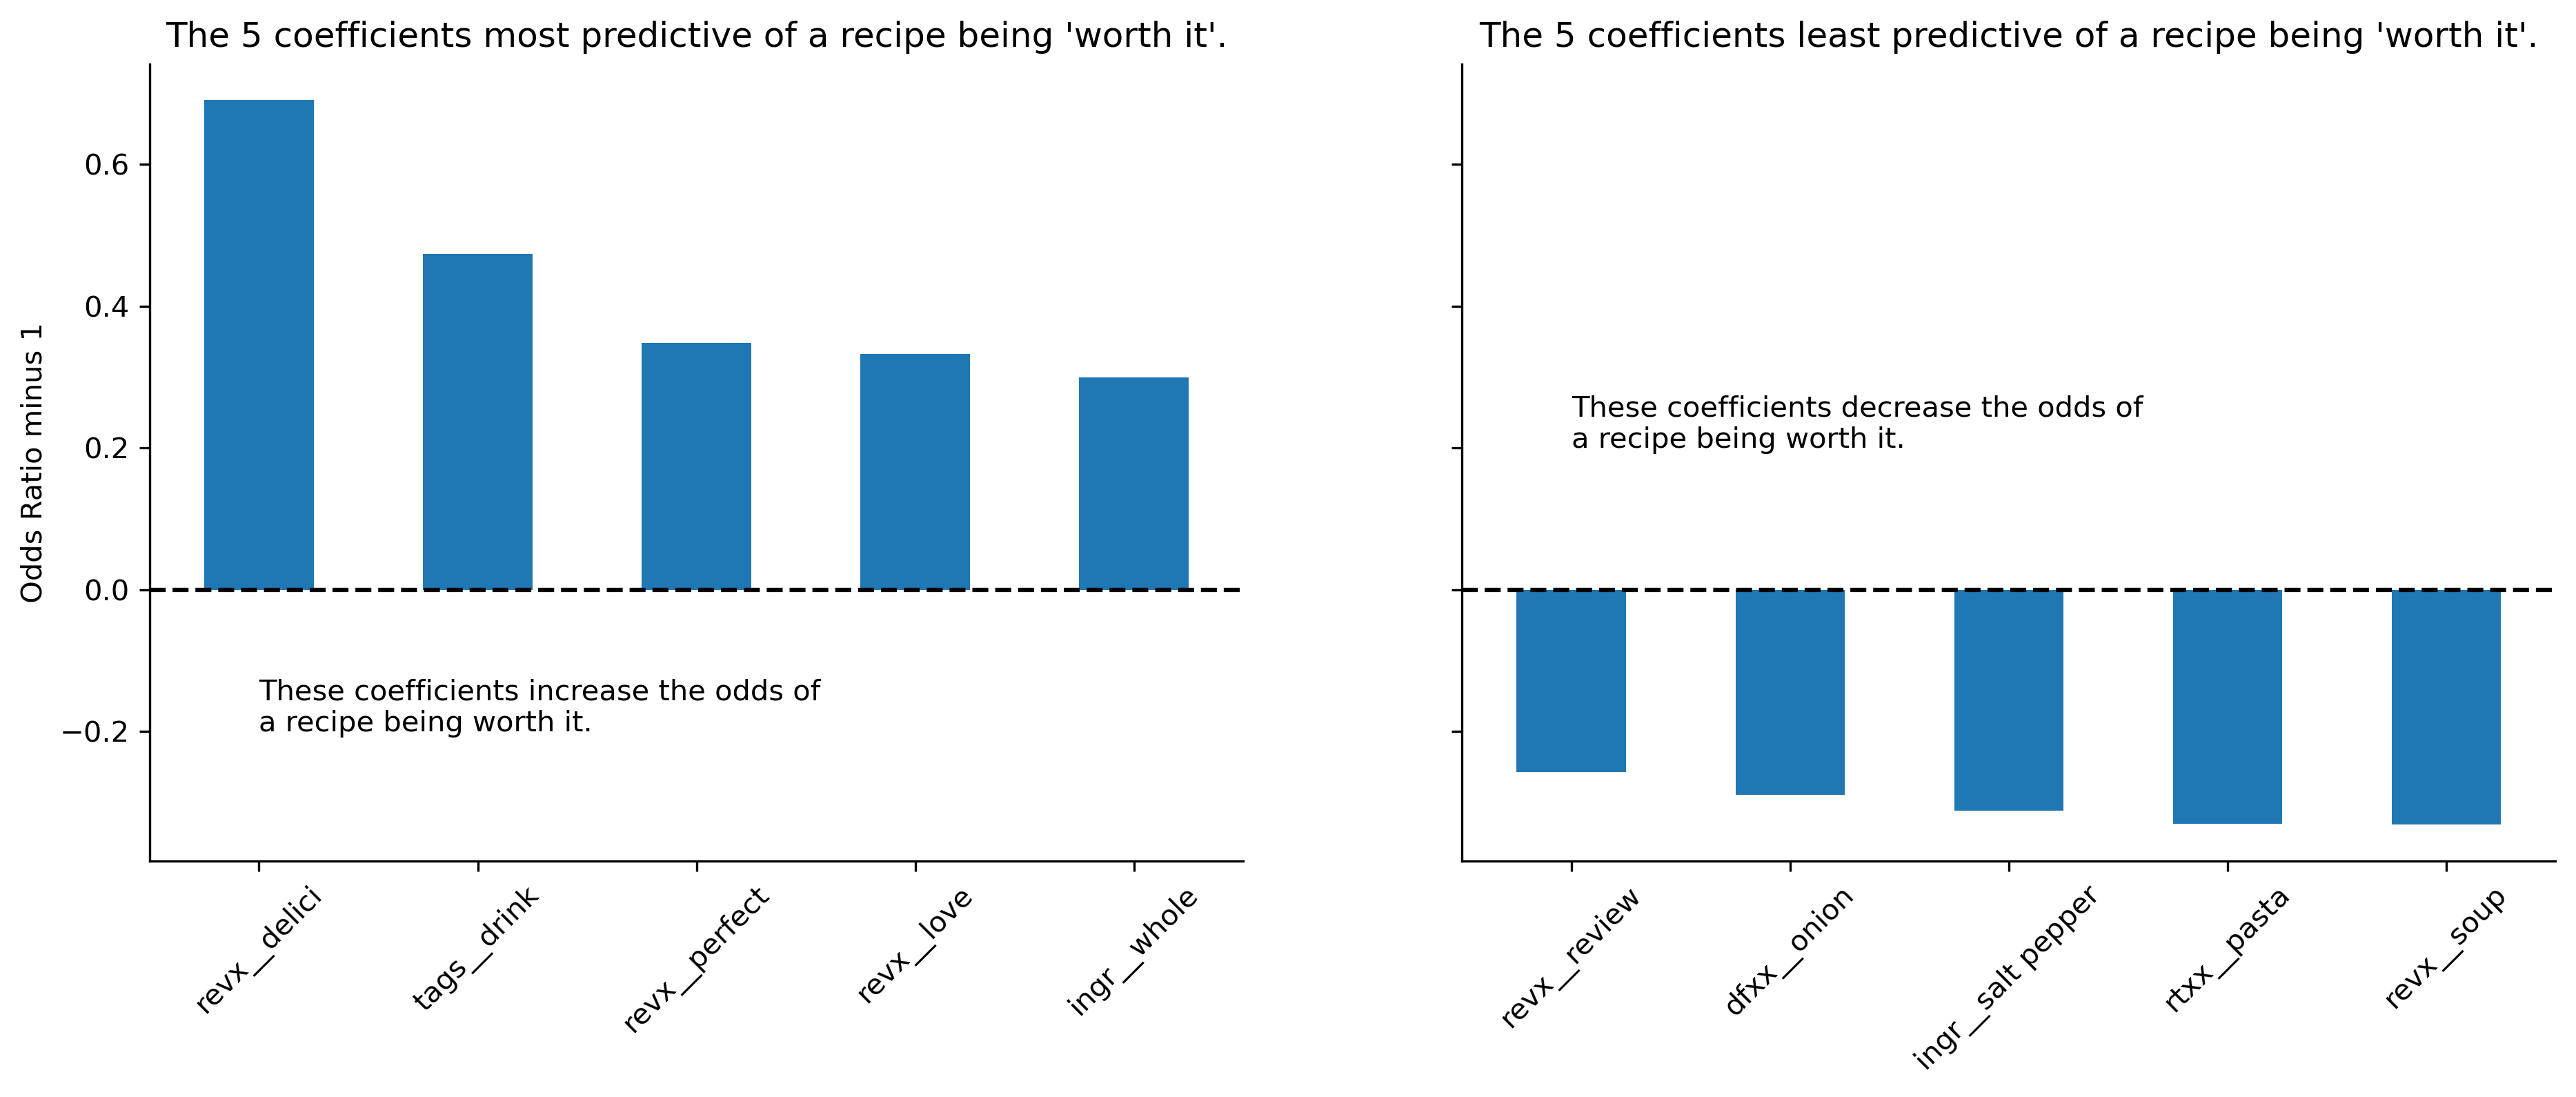

In [441]:
# Plot for presentation
# The coefficients were loaded into a DataFrame, with the labels being the column names of training data
final_model_coef = pd.DataFrame(
    {"coefficients": final_model.coef_[0]},
    index=X_test_t.columns
)

# Show top 5 coeffiecients
top_coef = final_model_coef.sort_values(by = 'coefficients', ascending = False).head(5)

# Show bottom 5 coeffiecients
bot_coef = final_model_coef.sort_values(by = 'coefficients', ascending = False).tail(5)

# Calculate odds ratio
top_coef['odds_ratio'] = np.exp(top_coef['coefficients'])
bot_coef['odds_ratio'] = np.exp(bot_coef['coefficients'])

plt.subplots(1,2,figsize = (15,5), sharey = True, dpi = 300)

plt.subplot(1,2,1)
(top_coef['odds_ratio']-1).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 5 coefficients most predictive of a recipe being 'worth it'.")
plt.ylabel("Odds Ratio minus 1")
plt.xticks(rotation=45)
plt.axhline(y=0, linestyle = '--', color = 'black')
plt.annotate('These coefficients increase the odds of\na recipe being worth it.',xy = (0,-0.2))
sns.despine()

plt.subplot(1,2,2)
(bot_coef['odds_ratio']-1).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 5 coefficients least predictive of a recipe being 'worth it'.")
plt.ylabel("Odds Ratio")
plt.xticks(rotation=45)
plt.axhline(y=0, linestyle = '--', color = 'black')
plt.annotate('These coefficients decrease the odds of\na recipe being worth it.',xy = (0,0.2))
sns.despine()
plt.savefig('images/coefficients.png', dpi = 300)
plt.show()

# Conclusion

In conclusion, a logistic regression model was chosen as the final model eventhough it was outperformed by a tuned XGBoost model. The reason was that strongest coefficients for logistic regression were a combination of different columns whereas the top coefficients for the XGBoost model were all from the single column `review`, for which not every recipe has. Furthermore, the performance of the final logistic regression model was only 1% behind the tuned XGBoost model, further supporting the use of logisitic regression to provide a more robust model that depends on a balanced mixture of columns for predictions. Although the accuracy can be further improved with the use of more advanced models and hyperparameter tuning, the project has yielded a deeper understanding of what makes a recipe worth it.

Building on top of the current project, a content based recommendation system can be built by measuring the cosine similarity of the recipes based on processed and engineered features. Finally, a text generator can be trained to generate recipes, groceries and even meal plans to further ease the process of homecooking for the working adult.

| model name  | hyperparameters                                                                                                                        | train <br>accuracy    | validation <br>accuracy | precision of <br>'worth it' class | recall of<br>'worth it' class  | train-time <br>(seconds) |
|-------------|----------------------------------------------------------------------------------------------------------------------------------------|-----------------------|-------------------------|-----------------------------------|--------------------------------|------------------------|
| baseline    | blindly guessing all recipes as worth it                                                                                               | 58.48%                | 58.48%                  | -                                 | -                              | -                      |
| model_lr0   | default, no PCA, log, standard scaler                                                                                                  | 78.58%                | 76.03%                  | 0.78                              | 0.82                           | 9.71                   |
| model_knn0  | default, no PCA, log, standard scaler                                                                                                  | 74.41%                | 61.57%                  | 0.64                              | 0.78                           | 18.29                  |
| model_rf0   | default, no PCA                                                                                                                        | 100.00%               | 73.77%                  | 0.72                              | 0.90                           | 22.35                  |
| model_gb0   | default, no PCA                                                                                                                        | 78.45%                | 75.64%                  | 0.76                              | 0.85                           | 154.61                 |
| model_xg0   | default, no PCA                                                                                                                        | 97.95%                | 75.46%                  | 0.77                              | 0.83                           | 44.78                  |
| model_xg1   | default, no PCA, log                                                                                                                   | 97.95%                | 75.46%                  | 0.77                              | 0.83                           | 45.16                  |
| model_xg2   | default, no PCA, log, standard scaler                                                                                                  | 97.95%                | 75.46%                  | 0.77                              | 0.83                           | 44.90                  |
| model_xg3   | default, no PCA,    , standard scaler                                                                                                  | 97.95%                | 75.46%                  | 0.77                              | 0.83                           | 44.61                  |
| model_xg4   | no PCA, no log, no standard scaler<br>Best parameters from GridSearchCV:<br>learning_rate = 0.1<br>max_depth = 3<br>n_estimators = 300 | 83.38%                | 77.28%                  | 0.78                              | 0.85                           | 73.13                  |
| model_lr1   | no PCA, log, robust scaler, C = 0.03                                                                                                   | 77.68%                | 76.52%                  | 0.78                              | 0.83                           | 200.06                 |
| =========== | ========================================                                                                                               | ========              | ===========             | ================                  | ================               | =========              |
|             | hyperparameters                                                                                                                        | Remainder<br>Accuracy | Test<br>Accuracy        | precision of <br>'worth it' class | recall of <br>'worth it' class | run-time               |
| final_model | no PCA, log, robust scaler, C=0.03                                                                                                     | 77.72%                | 76.36%                  | 0.78                              | 0.83                           | 325.95                 |

# Exporting the Final Model

In [448]:
joblib.dump(final_model, 'model/final_model.pkl')

['model/final_model.pkl']